In [1]:
# Transforming the ALFRED dataset
from utils import *

ALFRED_JSON_PATTERN = '../datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json' 
train_dataset = load_next_alfred_data(ALFRED_JSON_PATTERN)
print('train dataset size: ', len(train_dataset))
print('%3f kb' % (sys.getsizeof(train_dataset) / 1024.0))


100%|██████████| 255/255 [00:03<00:00, 80.24it/s]

train dataset size:  255
2.171875 kb


In [ ]:
# OPTIONAL: Filter dataset

import random

dataset25 = filtered_dataset_copy(train_dataset, 'FloorPlan25')
# A little random sample for testing
print('dataset samples: ', len(dataset25))
for i in range(1):
    print('*' * 20)
    example = dataset25[0] #random.choice(dataset25)
    #print(example[1]['floor_plan'])
    #print(example[1]['object_poses'])
    print(example[1]['task_id'])
    for j in example[0]:
        print('-' * 20)
        print(j['task_desc'])
        print(j['instructions'])

In [2]:
from models import *

m = CosineModel()
class T:
    x = torch.randn(4,10)
    edge_index = torch.randn(2, 4)

t = T()
m(t, torch.randn(10,10))


(tensor([-1.0245, -0.8789, -2.8083,  0.4511]),
 [tensor(3),
  tensor(3),
  tensor(3),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(3)])

In [3]:
# import ai2thor
import ai2thor.controller
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import torchtext
import spacy
import pandas as pd
import json, pickle, time
from tqdm.notebook import trange, tqdm

print(ai2thor.__version__)
controller = ai2thor.controller.Controller('Very Low', False, True)
controller.start()
controller.step(dict(action='Initialize', grid_size=0.5, headless=True, visibilityDistance=0.1, fieldOfView=90.0, renderObjectImage=False, renderClassImage=False, renderDepthImage=False))

from thor_environment import *

import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import copy

# Seed for reproduceability
np.random.seed(42)
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using: ',device)

# Experiment parameters
debug_instructions = False
debug_scores = False
debug_log = True
subset = train_dataset[:]
model = CosineModel().to(device)
nlp = spacy.load('en_core_web_sm')

# The test is for a multiple instructions intended to be executed over multiple timesteps of length 1
max_timesteps = 1 # TODO: Consider increasing to increase performance, niko used 10 i think.
reward = []
used_timesteps = []
trajectory_success = []
instruction_success = []
task_number = 0

# Experiment Log
if debug_log:
    debug_log_file = open('[BI-S] baseline_debug_log.tsv', 'w')
    debug_log_file.write("scene \t instruction \t expected_object \t expected_affordance \t actual_object \t actual_affordance \t success\n")

# run for each instruction in a task
for task in subset:
    trajectories, scene = task
    
    scene_name = "FloorPlan%d" % scene['scene_num']
    task_id = scene['task_id']
    object_poses = scene['object_poses']
    object_toggles = scene['object_toggles']
    dirty_and_empty = scene['dirty_and_empty']
    init_action = scene['init_action']
    
    # ALFRED has a custom initialised scene for each task
    # This is expensive, every task requires new initalisations and therefore new explorations
    environment_file = "../saved_environments/{}_{}.gz".format(scene_name, task_id)
    
    episode = {'log_probs':[], 'rewards':[], 'timesteps':0, 'entropy':[]}
    done = False
    t = 0
    task_number += 1
    print(" --- %d / %d --- %s" % (task_number, len(subset), task_id))
    
    for traj_idx, traj in enumerate(trajectories):
        # Each trajectory in a task uses the same environment but must be reset
        # each trajectory.
        controller.reset(scene_name)
        env = ThorEnvironment(controller=controller)
        event = controller.step(dict(action='Pass'))
        
        if os.path.isfile(environment_file):
            # load file, if exists
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Loading environment...')
            env.graph = env.graph.from_pickle(environment_file)
            if not hasattr(env.graph, 'robot_node'):
                env.graph.setup()
            print('Done')
        else:
            # explore and save
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Exploring environment...')
            env.explore_environment()
            env.graph.setup()
            print('Saving environment...')
            env.graph.to_pickle(environment_file)
            print('Done')
        
        print('Graph size (nodes): ', len(env.graph))
        #draw_graph(env.graph)
        complete_trajectory = True
        
        if not valid_trajectory(env, traj):
            print('[CHECK] Invalid trajectory. Skipping...')
            continue
        else:
            print('[CHECK] Valid Trajectory!')
        
        if debug_instructions:
            print("Task Trajectory: %d / %d (%d instructions)" % (traj_idx+1, len(trajectories), len(traj['instructions'])))
            print('High level objective: %s | Task Num: %s' % (traj['task_desc'], task_id))
        
        for inst_idx, instruction in enumerate(traj['instructions']):
            if debug_instructions:
                print('-----> Instruction %d / %d' % (inst_idx + 1, len(traj['instructions'])))            
            
            target_object = instruction['argument_1']
            if not instruction['argument_2'] == '<unk>': # ALFRED PutObject actions receptical as argument_2. 
                target_object = instruction['argument_2']
            
            target_affordance = instruction['action']
            
            if debug_instructions:
                print("Target affordance: %s -> %s\nTarget Instruction: %s" % (instruction['action'], target_object, ' '.join(instruction['instruction'])))
            pos_tags = nlp(' '.join(instruction['instruction']))
            #print([(t.text, t.tag_) for t in pos_tags])
            
            verbs = list(filter(lambda x: x.tag_[0] == 'V', pos_tags))
            verb_embedding = [env.graph.word2vec(word.lemma_) for word in verbs]
            
            nouns = list(filter(lambda x: x.tag_[0] == 'N', pos_tags))
            noun_embedding = [env.graph.word2vec(word.lemma_) for word in nouns]
            
            #target_embedding = [env.graph.word2vec(word.lower()) for word in instruction['instruction']]

            #done = False
            for timestep in range(max_timesteps):
                
                env.graph.to_torch_graph()
                
                # Target nouns to find relevant objects
                noun_target = torch.tensor(noun_embedding, dtype=torch.float).to(device)
                noun_logits, _ = model(env.graph._torch_graph, noun_target)
                
                obj_mask = torch.tensor(env.graph._torch_affordance_mask==1, dtype=torch.bool).to(device)
                # Add robot node to mask
                obj_mask[env.graph.robot_node] = True
                relevant_objects = torch.argsort(noun_logits, descending=True)
                relevant_objects = [node for node in relevant_objects if not obj_mask[node]][:1]
                
                relevant_affordance_mask = [] # Only affordances that are successors of the relevant objects
                for rel_obj in relevant_objects:
                    relevant_affordance_mask.extend(env.graph.get_affordances(env.graph.from_torch_id(rel_obj.item())))
                
                relevant_nodes = []
                for n in relevant_objects:
                    n = env.graph.nodes[env.graph.from_torch_id(n.item())]
                    if n['node_type'] == 'object':
                        relevant_nodes.append(n['obj'])
                print(f"found target nouns:{nouns} relevant nodes: {relevant_nodes}")
                
                # Target verbs to find relevant affordances
                verb_target = torch.tensor(verb_embedding, dtype=torch.float).to(device)
                verb_logits, _ = model(env.graph._torch_graph, verb_target)
                
                # we only care about the affordance nodes, so set the logits of all other nodes to something very small
                affordance_mask = torch.tensor(env.graph._torch_affordance_mask==0, dtype=torch.bool).to(device)
                verb_logits[affordance_mask] = -1000
                verb_logits[relevant_affordance_mask] += 1000 # Markup the relevant object's affordances
                print(f"found target verbs:{verbs} relevant verbs: {[env.graph.nodes[env.graph.from_torch_id(n.item())]['affordance'] for n in torch.argsort(verb_logits, descending=True)[:5]]}")
                
                # sample an action from the output of the model
                action = torch.argmax(verb_logits)
                affordance = env.graph.from_torch_id(action.item())
                
                correct_affordance = False
                actual_affordance = env.graph.nodes[affordance]['affordance']
                
                if actual_affordance == normalize_action_name(target_affordance):
                    correct_affordance = True
                
                r = 0.0
                succ, pred = env.graph.get_related_objects(affordance)
                
                correct_object = False
                actual_object = None
                
                if not pred is None:
                    for n in pred:
                        actual_object = env.graph.nodes[n]['obj']
                        if actual_object == target_object:
                            if correct_affordance:
                                r = 1.0
                                #done = True
                                correct_object = True
                                env.step(action.item()) # An Action is an affordance in the graph
                                # TODO: If action cannot be executed, break loop and print error. 
                                break
                
                print("Target: %s -> %s \t Actual: %s -> %s [%s]" % (normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_affordance and correct_object))
                #assert False

                if correct_affordance and correct_object:
                    instruction_success.append((1.0, normalize_action_name(target_affordance), len(instruction['instruction'])))
                else:
                    complete_trajectory = False
                    instruction_success.append((0.0, normalize_action_name(target_affordance), len(instruction['instruction'])))
                
                if debug_log:
                    debug_log_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (scene_name, ' '.join(instruction['instruction']), normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_object and correct_affordance))
                
                episode['rewards'].append(r)
                episode['timesteps'] = t
        
        if complete_trajectory:
            trajectory_success.append(1.0)
        else:
            trajectory_success.append(0.0)
    
    # === end of an episode ===
    used_timesteps.append(t)
    
    reward.append(np.sum(episode['rewards']))

if debug_log:
    debug_log_file.close()

2.1.0
Using:  cpu
 --- 1 / 255 --- trial_T20190908_145356_918528
Loading environment...
Done
Graph size (nodes):  417
[CHECK] Valid Trajectory!
found target nouns:[stand, side, trash, bin] relevant nodes: ['garbagecan']
found target verbs:[walk, turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[apple, trash, bin] relevant nodes: ['garbagecan']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> apple 	 Actual: go -> garbagecan [False]
found target nouns:[turn, head, microwave, left] relevant nodes: ['microwave']
found target verbs:[left, turn] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Target: go -> microwave 	 Actual: go -> microwave [True]
found target nouns:[microwave, microwave, microwave] relevant nodes: ['microwave']
found target verbs:[open, put, take, close] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: heat -> apple 	 Actual: put -> microwave [False]
found target nouns:[walk, step, trash, bin] relevant nodes: ['garbagecan']
found target verbs:[turn, left, turn, left, walk, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[apple, trash, bin] relevant nodes: ['garbagecan']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
Graph size (nodes):  417
[CHECK] Valid Trajectory!
found target nouns:[right, trash, counter] relevant nodes: ['garbagecan']
found target verbs:[go, turn, fac

Loading environment...
Done
Graph size (nodes):  419
[CHECK] Valid Trajectory!
found target nouns:[bit, garbage, bin, left] relevant nodes: ['garbagecan']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[apple, garbage, bin] relevant nodes: ['garbagecan']
found target verbs:[grab] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: pick -> apple 	 Actual: put -> garbagecan [False]
found target nouns:[kitchen, stove, end, side, room, microwave, stove] relevant nodes: ['stoveburner']
found target verbs:[turn, left, walk, look] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveburner [False]
found target nouns:[apple, microwave, cook] relevant nodes: ['microwave']
found target verbs:[place, take] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: heat -> apple 	 Actual: put -> microwave [False]
found target nouns:[fridge, side

Loading environment...
Done
Graph size (nodes):  412
[CHECK] Valid Trajectory!
found target nouns:[walk, left, counter, top] relevant nodes: ['countertop']
found target verbs:[turn, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[egg, counter, top, trophy] relevant nodes: ['egg']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Egg|+01.03|+00.95|-00.03 is not visible.
Target: pick -> egg 	 Actual: pick -> egg [True]
found target nouns:[refrigerator, refrigerator, door] relevant nodes: ['fridge']
found target verbs:[turn, face, open] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> fridge 	 Actual: put -> fridge [False]
found target nouns:[egg, refrigerator, tomato, door, door, egg] relevant nodes: ['egg']
found target verbs:[place, close, open, pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'slice']
Target: cool -> egg 	 Ac

Loading environment...
Done
Graph size (nodes):  236
[CHECK] Valid Trajectory!
found target nouns:[side, tan, sofa, credit, card] relevant nodes: ['sofa']
found target verbs:[move, is] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sofa 	 Actual: go -> sofa [True]
found target nouns:[credit, card, top, sofa] relevant nodes: ['sofa']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> creditcard 	 Actual: go -> sofa [False]
found target nouns:[credit, card, corner, room, floor, lamp] relevant nodes: ['floorlamp']
found target verbs:[carry, facing] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
found target nouns:[lamp] relevant nodes: ['lamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> lamp [False]
Loading environment...
Done
Graph size (nodes):  236
[CHECK] Valid Trajectory!
found target 

found target nouns:[chair, couch, floor, lamp] relevant nodes: ['lamp']
found target verbs:[turn, walk, turn, face] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> lamp [False]
found target nouns:[lamp] relevant nodes: ['lamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> lamp [False]
 --- 10 / 255 --- trial_T20190908_215019_162873
Loading environment...
Done
Graph size (nodes):  158
[CHECK] Valid Trajectory!
found target nouns:[left, toilet] relevant nodes: ['toilet']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> toilet 	 Actual: put -> toilet [False]
found target nouns:[bar, soap, back, toilet] relevant nodes: ['toilet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> soapbar 	 Actual: go -> toilet [False]
found target nouns:[left, sink, left, toilet] relevant nodes: ['

Loading environment...
Done
Graph size (nodes):  132
[CHECK] Valid Trajectory!
found target nouns:[counter, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
found target nouns:[bar, soap, back, counter, sink] relevant nodes: ['sinkbasin']
found target verbs:[pick, is] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> soapbar 	 Actual: go -> sinkbasin [False]
found target nouns:[right, sink, right] relevant nodes: ['sink']
found target verbs:[move, face] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[bar, soap, sink, turn, water, soap, water, soap, sink] relevant nodes: ['soapbottle']
found target verbs:[put, rinse, turn, remove] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: clean -> soapbar 	 Actual: go -> soapbottle [False]
found target nouns:[si

Loading environment...
Done
Graph size (nodes):  384
[CHECK] Valid Trajectory!
found target nouns:[veer, counter, walk, sink, counter] relevant nodes: ['sink']
found target verbs:[walk, getting] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[tomato, sink] relevant nodes: ['sinkbasin']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> tomato 	 Actual: go -> sinkbasin [False]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[tomato, fridge, front, center, brown, bowl, door, moment] relevant nodes: ['fridge']
found target verbs:[place, close, wait, take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: cool -> tomato 	 Actual: go -> fridge [False]
found target nouns:[stove] relevant nodes: ['stoveburner']
found 

Loading environment...
Done
Graph size (nodes):  404
[CHECK] Valid Trajectory!
found target nouns:[sink] relevant nodes: ['sinkbasin']
found target verbs:[walk, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[butter, knife, sponge, counter] relevant nodes: ['butterknife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False ButterKnife|-01.29|+00.93|-00.91 is not visible.
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
found target nouns:[left, stove] relevant nodes: ['stoveknob']
found target verbs:[walk, face] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> cup 	 Actual: go -> stoveknob [False]
found target nouns:[knife, cup, left, counter] relevant nodes: ['knife']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> cup 	 Actual: go -> knife [False]
found target nouns:[cup, coun

Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[cup, sink] relevant nodes: ['sinkbasin']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
found target nouns:[butter, knife, sink] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> butterknife 	 Actual: pick -> knife [False]
found target nouns:[butter, knife, cup, sink] relevant nodes: ['butterknife']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> cup 	 Actual: go -> butterknife [False]
 --- 18 / 255 --- trial_T20190909_025413_784807
Loading environment...
Done
Graph size (nodes):  413
[CHECK] Valid Trajectory!
found target nouns:[fridge, sink] relevant nodes: ['fridge']
found target verbs:[go, turn, move, turn, left, face] relevant ve

PickupObject False CD|-00.74|+00.86|-00.66 is not visible.
Target: pick -> cd 	 Actual: pick -> cd [True]
found target nouns:[bed, bin, vault, left] relevant nodes: ['bed']
found target verbs:[turn, turn, left, turn] relevant verbs: ['go', 'go', 'put', 'clean', 'go']
Target: go -> safe 	 Actual: go -> bed [False]
found target nouns:[cd, vault] relevant nodes: ['cd']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'put']
Target: put -> safe 	 Actual: go -> cd [False]
Loading environment...
Done
Graph size (nodes):  233
[CHECK] Valid Trajectory!
found target nouns:[desk, widow] relevant nodes: ['desk']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> desk 	 Actual: put -> desk [False]
found target nouns:[cd, desk] relevant nodes: ['desk']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> cd 	 Actual: go -> desk [False]
found target nouns:[right, left, mirror] relevant nodes: 

found target nouns:[] relevant nodes: ['laptop']
found target verbs:[turn, go] relevant verbs: ['go', 'pick', 'cool', 'toggle', 'heat']
Target: go -> safe 	 Actual: go -> laptop [False]
found target nouns:[put, cd, close] relevant nodes: ['cd']
found target verbs:[open] relevant verbs: ['pick', 'cool', 'go', 'heat', 'clean']
Target: put -> safe 	 Actual: pick -> cd [False]
Loading environment...
Done
Graph size (nodes):  223
[CHECK] Valid Trajectory!
found target nouns:[desk, window] relevant nodes: ['desk']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desk 	 Actual: go -> desk [True]
found target nouns:[cd, desk] relevant nodes: ['cd']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False CD|-01.92|+00.88|+00.58 is not visible.
Target: pick -> cd 	 Actual: pick -> cd [True]
found target nouns:[mirror] relevant nodes: ['mirror']
found target verbs:[turn, walk] relevant verbs: ['go', 'clean', 

found target nouns:[turn, door] relevant nodes: ['window']
found target verbs:[turn, go, left, go, open] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> safe 	 Actual: go -> window [False]
found target nouns:[cd, door] relevant nodes: ['cd']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'put']
Target: put -> safe 	 Actual: go -> cd [False]
 --- 22 / 255 --- trial_T20190908_073839_704604
Loading environment...
Done
Graph size (nodes):  411
[CHECK] Valid Trajectory!
found target nouns:[walk, fridge, head, sink] relevant nodes: ['fridge']
found target verbs:[move, turn, turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> fridge [False]
found target nouns:[knife, sink] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> butterknife 	 Actual: pick -> knife [False]
found target nouns:[trash, bin] relevant nodes: ['garbagecan']
found target 

found target nouns:[apple, white, vase] relevant nodes: ['apple']
found target verbs:[cut, is] relevant verbs: ['slice', 'go', 'pick', 'cool', 'heat']
SliceObject False object not found: Apple|+00.69|+00.96|+00.14
Target: slice -> apple 	 Actual: slice -> apple [True]
found target nouns:[knife, walk, turn, trash] relevant nodes: ['knife']
found target verbs:[holding, left, turn, left, face] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: go -> garbagecan 	 Actual: go -> knife [False]
found target nouns:[knife, trash] relevant nodes: ['knife']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> garbagecan 	 Actual: go -> knife [False]
found target nouns:[counter, top, apple] relevant nodes: ['apple']
found target verbs:[go, cut] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: go -> countertop 	 Actual: go -> apple [False]
found target nouns:[slice, apple, top, counter, top] relevant nodes: ['countertop']
found target

found target nouns:[knife, bin] relevant nodes: ['knife']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> garbagecan 	 Actual: go -> knife [False]
found target nouns:[section, apple] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|-00.91|+00.23|+00.61 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[move, front, microwave] relevant nodes: ['microwave']
found target verbs:[turn, left] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> microwave 	 Actual: go -> microwave [True]
found target nouns:[apple, section, microwave, cook] relevant nodes: ['microwave']
found target verbs:[put, pick] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: heat -> apple 	 Actual: put -> microwave [False]
found target nouns:[move, bin, end, island] relevant nodes: ['garbagecan']
found target verbs:[turn, left] r

found target nouns:[floor, lamp] relevant nodes: ['floorlamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 26 / 255 --- trial_T20190908_041333_727215
Loading environment...
Done
Graph size (nodes):  239
[CHECK] Valid Trajectory!
found target nouns:[white, shelf] relevant nodes: ['shelf']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> shelf 	 Actual: go -> shelf [True]
found target nouns:[statue, trophy, shelf] relevant nodes: ['statue']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Statue|-00.19|+01.11|+01.19 is not visible.
Target: pick -> statue 	 Actual: pick -> statue [True]
found target nouns:[lamp] relevant nodes: ['floorlamp']
found target verbs:[turn, walk] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
found target noun

Loading environment...
Done
Graph size (nodes):  386
[CHECK] Valid Trajectory!
found target nouns:[room, right, coffee, machine, counter] relevant nodes: ['coffeemachine']
found target verbs:[begin, walking, hang, walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> coffeemachine 	 Actual: go -> coffeemachine [True]
found target nouns:[white, mug, coffee, machine, counter] relevant nodes: ['coffeemachine']
found target verbs:[pick, is] relevant verbs: ['go', 'put', 'toggle', 'pick', 'pick']
Target: pick -> mug 	 Actual: go -> coffeemachine [False]
found target nouns:[wall, right, fridge] relevant nodes: ['fridge']
found target verbs:[turn, walk, hang, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[fridge, door, mug, shelf, door, couple, fridge, mug, fridge, door] relevant nodes: ['fridge']
found target verbs:[open, put, close, open, remove, close] relevant verbs: ['put', 'go', 'put', 'put',

found target nouns:[walk, kitchen, coffee, maker, turn, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[turn, left, stop, face] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> coffeemachine 	 Actual: go -> coffeemachine [True]
found target nouns:[place, mug, coffee, maker, top, counter] relevant nodes: ['coffeemachine']
found target verbs:[] relevant verbs: ['toggle', 'go', 'put', 'go', 'go']
Target: put -> coffeemachine 	 Actual: toggle -> coffeemachine [False]
Loading environment...
Done
Graph size (nodes):  382
[CHECK] Valid Trajectory!
found target nouns:[left, counter, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[turn, head] relevant verbs: ['put', 'go', 'toggle', 'pick', 'pick']
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
found target nouns:[mug, coffee, maker, counter] relevant nodes: ['coffeemachine']
found target verbs:[pick] relevant verbs: ['go', 'toggle', 'put', 'pick', 'pick']
Target: pick -

found target nouns:[bowl, cupboard] relevant nodes: ['bowl']
found target verbs:[put] relevant verbs: ['put', 'go', 'clean', 'pick', 'cool']
Target: put -> cabinet 	 Actual: put -> bowl [False]
Loading environment...
Done
Graph size (nodes):  389
[CHECK] Valid Trajectory!
found target nouns:[toaster, counter, right, cabinet] relevant nodes: ['cabinet']
found target verbs:[turn, walk, look] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> cabinet [True]
found target nouns:[bowl, cabinet] relevant nodes: ['cabinet']
found target verbs:[grab] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: pick -> bowl 	 Actual: put -> cabinet [False]
found target nouns:[sink, right] relevant nodes: ['sink']
found target verbs:[turn, walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[bowl, water, bowl] relevant nodes: ['bowl']
found target verbs:[fill, grab] relevant verbs: ['put', 'p

Loading environment...
Done
Graph size (nodes):  406
[CHECK] Valid Trajectory!
found target nouns:[counter, right, fridge] relevant nodes: ['fridge']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[loaf, bread, counter] relevant nodes: ['bread']
found target verbs:[grab] relevant verbs: ['pick', 'go', 'slice', 'cool', 'heat']
PickupObject False Bread|-01.36|+01.01|-00.91 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[look] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[bread, counter] relevant nodes: ['bread']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> countertop 	 Actual: go -> bread [False]
found target nouns:[knife, counter] relevant nodes: ['knife

Loading environment...
Done
Graph size (nodes):  427
[CHECK] Valid Trajectory!
found target nouns:[counter, left] relevant nodes: ['countertop']
found target verbs:[look, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[bread, counter, toaster] relevant nodes: ['toaster']
found target verbs:[pick] relevant verbs: ['go', 'toggle', 'put', 'pick', 'pick']
Target: pick -> bread 	 Actual: go -> toaster [False]
found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[look, face] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[bread, counter] relevant nodes: ['bread']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> countertop 	 Actual: go -> bread [False]
found target nouns:[knife, counter] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pic

Loading environment...
Done
Graph size (nodes):  392
[CHECK] Valid Trajectory!
found target nouns:[left, center, table, sink] relevant nodes: ['sink']
found target verbs:[walk, turn, face] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sink [False]
found target nouns:[knife, table] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Knife|-00.55|+00.96|-00.14 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
found target nouns:[bread, center, table] relevant nodes: ['bread']
found target verbs:[turn, step, turn, face] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: go -> bread 	 Actual: go -> bread [True]
found target nouns:[bread, center, table, slice] relevant nodes: ['bread']
found target verbs:[cut] relevant verbs: ['slice', 'pick', 'go', 'heat', 'cool']
SliceObject False object not found: Bread|-00.78|+01.00|+00.21
Target: slice -> b

found target verbs:[pick, is] relevant verbs: ['go', 'clean', 'pick', 'pick', 'pick']
Target: pick -> soapbar 	 Actual: go -> mirror [False]
found target nouns:[door] relevant nodes: ['toilet']
found target verbs:[turn, walk, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> toilet [False]
found target nouns:[bar, soap, golden] relevant nodes: ['soapbottle']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> garbagecan 	 Actual: go -> soapbottle [False]
Loading environment...
Done
Graph size (nodes):  159
[CHECK] Valid Trajectory!
found target nouns:[counter, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, left, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[soap, front, candle] relevant nodes: ['candle']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'toggle', 'heat', 'cool']
Target: pi

Loading environment...
Done
Graph size (nodes):  152
[CHECK] Valid Trajectory!
found target nouns:[center, bathroom, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[bar, soap, bathroom, sink, counter, sink] relevant nodes: ['sink']
found target verbs:[grab] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: pick -> soapbar 	 Actual: go -> sink [False]
found target nouns:[side, corner, room, garbage, bin] relevant nodes: ['garbagecan']
found target verbs:[turn, walk, is] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[bar, garbage, bin] relevant nodes: ['garbagecan']
found target verbs:[place] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -

found target nouns:[lettuce, sink] relevant nodes: ['sink']
found target verbs:[rinse, pick] relevant verbs: ['go', 'pick', 'pick', 'pick', 'pick']
Target: clean -> lettuce 	 Actual: go -> sink [False]
found target nouns:[end, counter, trash] relevant nodes: ['bowl']
found target verbs:[turn, go, turn, left, go] relevant verbs: ['pick', 'go', 'heat', 'cool', 'clean']
Target: go -> garbagecan 	 Actual: pick -> bowl [False]
found target nouns:[lettuce, trash, bottle] relevant nodes: ['lettuce']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> garbagecan 	 Actual: go -> lettuce [False]
Loading environment...
Done
Graph size (nodes):  384
[CHECK] Valid Trajectory!
found target nouns:[toaster] relevant nodes: ['toaster']
found target verbs:[go] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> toaster [False]
found target nouns:[knife, toaster] relevant nodes: ['toaster']
found target verbs:[pick] rele

Loading environment...
Done
Graph size (nodes):  393
[CHECK] Valid Trajectory!
found target nouns:[counter, dishwasher] relevant nodes: ['countertop']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[knife] relevant nodes: ['knife']
found target verbs:[take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: pick -> butterknife 	 Actual: go -> knife [False]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[go] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> lettuce 	 Actual: go -> fridge [False]
found target nouns:[lettuce, fridge] relevant nodes: ['fridge']
found target verbs:[cut] relevant verbs: ['put', 'go', 'go', 'slice', 'slice']
Target: slice -> lettuce 	 Actual: put -> fridge [False]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, look] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go ->

SliceObject False object not found: Lettuce|+01.03|+00.99|+00.14
Target: slice -> lettuce 	 Actual: slice -> lettuce [True]
found target nouns:[middle, counter] relevant nodes: ['countertop']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[butterknife] relevant nodes: ['butterknife']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> countertop 	 Actual: go -> butterknife [False]
found target nouns:[part, counter] relevant nodes: ['countertop']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[lettuce, piece] relevant nodes: ['lettuce']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Lettuce|+00.91|+00.94|+01.06 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
found t

[CHECK] Valid Trajectory!
found target nouns:[desk] relevant nodes: ['desk']
found target verbs:[walk, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> shelf 	 Actual: go -> desk [False]
found target nouns:[white, mug, desk] relevant nodes: ['mug']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'put', 'heat', 'clean']
PickupObject False Mug|-00.40|+00.86|-01.53 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
found target nouns:[desk] relevant nodes: ['desk']
found target verbs:[step, continue, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desklamp 	 Actual: go -> desk [False]
found target nouns:[desk, lamp, desk] relevant nodes: ['desk']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desk [False]
Loading environment...
Done
Graph size (nodes):  226
[CHECK] Valid Trajectory!
found target nouns:[left, desk] relevant nodes: ['desk']
found target verbs:[

found target nouns:[mug, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[put] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> coffeemachine 	 Actual: put -> coffeemachine [True]
Loading environment...
Done
Graph size (nodes):  407
[CHECK] Valid Trajectory!
found target nouns:[coffee, pot] relevant nodes: ['coffeemachine']
found target verbs:[walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
found target nouns:[coffee, cup, coffee, pot] relevant nodes: ['coffeemachine']
found target verbs:[grab, is] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: pick -> mug 	 Actual: put -> coffeemachine [False]
found target nouns:[cup, microwave] relevant nodes: ['cup']
found target verbs:[carry] relevant verbs: ['put', 'pick', 'go', 'clean', 'heat']
Target: go -> microwave 	 Actual: put -> cup [False]
f

found target nouns:[door, tomato, door, door, tomato, microwave] relevant nodes: ['tomato']
found target verbs:[open, put, open, take] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: heat -> tomato 	 Actual: go -> tomato [False]
found target nouns:[island, counter, trash] relevant nodes: ['garbagecan']
found target verbs:[go, facing] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[tomato, side, trash] relevant nodes: ['tomato']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> garbagecan 	 Actual: go -> tomato [False]
Loading environment...
Done
Graph size (nodes):  393
[CHECK] Valid Trajectory!
found target nouns:[dishwasher, right] relevant nodes: ['faucet']
found target verbs:[turn, walk, is] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> faucet [False]
found target nouns:[tomato, counter, dishwasher

[CHECK] Valid Trajectory!
found target nouns:[sink] relevant nodes: ['sink']
found target verbs:[turn, face] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[tomato, sink] relevant nodes: ['sink']
found target verbs:[pick] relevant verbs: ['go', 'pick', 'pick', 'pick', 'pick']
Target: pick -> tomato 	 Actual: go -> sink [False]
found target nouns:[microwave, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, face] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: go -> microwave 	 Actual: go -> stoveknob [False]
found target nouns:[tomato, microwave, door, door, tomato] relevant nodes: ['tomato']
found target verbs:[put, shut, open, pick] relevant verbs: ['pick', 'go', 'cool', 'slice', 'heat']
Target: heat -> tomato 	 Actual: pick -> tomato [False]
found target nouns:[trash] relevant nodes: ['garbagecan']
found target verbs:[go, left, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']


Loading environment...
Done
Graph size (nodes):  365
[CHECK] Valid Trajectory!
found target nouns:[end, kitchen, island, counter, left] relevant nodes: ['countertop']
found target verbs:[walk, turn, left, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[bread, kitchen, island, counter] relevant nodes: ['bread']
found target verbs:[grab] relevant verbs: ['pick', 'go', 'slice', 'cool', 'heat']
PickupObject False Bread|-01.10|+01.01|-00.12 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
found target nouns:[front, fridge, left] relevant nodes: ['fridge']
found target verbs:[turn, walk] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[bread, fridge] relevant nodes: ['bread']
found target verbs:[place, cool, take] relevant verbs: ['cool', 'go', 'heat', 'pick', 'slice']
! Error when executing PUT affordance: Agent does n

[CHECK] Valid Trajectory!
found target nouns:[side, sink, counter] relevant nodes: ['sinkbasin']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cloth 	 Actual: go -> sinkbasin [False]
found target nouns:[rag, counter] relevant nodes: ['countertop']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> cloth 	 Actual: go -> countertop [False]
found target nouns:[sink] relevant nodes: ['sink']
found target verbs:[walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[rag, sink, water, couple, water, rag] relevant nodes: ['sink']
found target verbs:[put, turn, turn, remove] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: clean -> cloth 	 Actual: go -> sink [False]
found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[turn, walk, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go ->

Loading environment...
Done
Graph size (nodes):  144
[CHECK] Valid Trajectory!
found target nouns:[sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[rag] relevant nodes: ['towel']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> cloth 	 Actual: pick -> towel [False]
found target nouns:[step] relevant nodes: ['countertop']
found target verbs:[take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
found target nouns:[rag, sink] relevant nodes: ['sink']
found target verbs:[wash] relevant verbs: ['go', 'clean', 'clean', 'clean', 'clean']
Target: clean -> cloth 	 Actual: go -> sink [False]
found target nouns:[step] relevant nodes: ['countertop']
found target verbs:[take, left] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> counte

found target nouns:[cup, counter] relevant nodes: ['cup']
found target verbs:[turn, bring] relevant verbs: ['put', 'go', 'pick', 'clean', 'cool']
Target: go -> countertop 	 Actual: put -> cup [False]
found target nouns:[cup, knife, counter, front, spoon, plate] relevant nodes: ['spoon']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> countertop 	 Actual: go -> spoon [False]
Loading environment...
Done
Graph size (nodes):  378
[CHECK] Valid Trajectory!
found target nouns:[counter, left, room, side, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, walk] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveknob [False]
found target nouns:[butter, knife, tomato, counter] relevant nodes: ['butterknife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False ButterKnife|-00.62|+00.93|-01.39 is not visible.
Target: pick -> butterknife 	 Actual: p

Loading environment...
Done
Graph size (nodes):  233
[CHECK] Valid Trajectory!
found target nouns:[bottom, side, cabinet] relevant nodes: ['cabinet']
found target verbs:[move, left] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> cabinet [True]
found target nouns:[vase, cabinet] relevant nodes: ['vase']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Vase|-04.67|+00.21|+04.33 is not visible.
Target: pick -> vase 	 Actual: pick -> vase [True]
found target nouns:[vase, floor, lamp, right] relevant nodes: ['floorlamp']
found target verbs:[carry] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
found target nouns:[lamp] relevant nodes: ['floorlamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 62 / 255 --- trial_T20190908_203635_515565
Loading

found target nouns:[trash] relevant nodes: ['garbagecan']
found target verbs:[go, left, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[potato, trash] relevant nodes: ['potato']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> garbagecan 	 Actual: go -> potato [False]
Loading environment...
Done
Graph size (nodes):  426
[CHECK] Valid Trajectory!
found target nouns:[refrigerator, counter, left, potato] relevant nodes: ['potato']
found target verbs:[turn, walk, turn, walk] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> countertop 	 Actual: go -> potato [False]
found target nouns:[potato, counter] relevant nodes: ['potato']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Potato|-00.70|+00.96|+00.32 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
found targ

Loading environment...
Done
Graph size (nodes):  450
[CHECK] Valid Trajectory!
found target nouns:[right, counter, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[go, face] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
found target nouns:[potato, counter] relevant nodes: ['potato']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Potato|+00.86|+00.94|-01.88 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
found target nouns:[microwave, stove] relevant nodes: ['stoveknob']
found target verbs:[go, face] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveknob [False]
found target nouns:[potato, microwave, door, door, potato, door] relevant nodes: ['potato']
found target verbs:[put, shut, open, pick, shut] relevant verbs: ['pick', 'go', 'cool', 'heat', 'slice']
Target: heat -> potato 

Loading environment...
Done
Graph size (nodes):  361
[CHECK] Valid Trajectory!
found target nouns:[head, kitchen, stove] relevant nodes: ['stoveburner']
found target verbs:[] relevant verbs: ['go', 'put', 'go', 'go', 'cool']
Target: go -> stoveburner 	 Actual: put -> stoveburner [False]
found target nouns:[pan, stove] relevant nodes: ['stoveburner']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> pan 	 Actual: go -> stoveburner [False]
found target nouns:[left, sink] relevant nodes: ['sinkbasin']
found target verbs:[head] relevant verbs: ['put', 'go', 'pick', 'pick', 'pick']
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
found target nouns:[pan, sink] relevant nodes: ['sinkbasin']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: clean -> pan 	 Actual: put -> sinkbasin [False]
found target nouns:[water, pan, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, take] relevant verbs: ['

Loading environment...
Done
Graph size (nodes):  442
[CHECK] Valid Trajectory!
found target nouns:[walk, wall, room, coffee, machine, counter] relevant nodes: ['coffeemachine']
found target verbs:[turn, turn, walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> coffeemachine [False]
found target nouns:[cabinet, coffee, machine, bowl, cabinet] relevant nodes: ['cabinet']
found target verbs:[open, take, close] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: pick -> bowl 	 Actual: go -> cabinet [False]
found target nouns:[cabinet, counter, top] relevant nodes: ['cabinet']
found target verbs:[bend, face] relevant verbs: ['put', 'go', 'slice', 'slice', 'slice']
Target: go -> countertop 	 Actual: put -> cabinet [False]
found target nouns:[bowl, counter, top, front, apple] relevant nodes: ['bowl']
found target verbs:[put] relevant verbs: ['put', 'go', 'clean', 'pick', 'cool']
Target: put -> countertop 	 Actual: put -> bowl [False]
found targe

found target nouns:[bowl, cabinet] relevant nodes: ['cabinet']
found target verbs:[remove] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: pick -> bowl 	 Actual: put -> cabinet [False]
found target nouns:[egg, bowl, cabinet, door] relevant nodes: ['egg']
found target verbs:[holding, close] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> countertop 	 Actual: go -> egg [False]
found target nouns:[bowl, counter] relevant nodes: ['bowl']
found target verbs:[place] relevant verbs: ['put', 'go', 'heat', 'pick', 'clean']
Target: put -> countertop 	 Actual: put -> bowl [False]
Loading environment...
Done
Graph size (nodes):  433
[CHECK] Valid Trajectory!
found target nouns:[left, step, refrigerator, right, step, left, counter] relevant nodes: ['countertop']
found target verbs:[turn, go, turn, go, turn, take, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[ball, counter, top

Loading environment...
Done
Graph size (nodes):  364
[CHECK] Valid Trajectory!
found target nouns:[head, stove] relevant nodes: ['stoveburner']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveburner [False]
found target nouns:[knife, counter] relevant nodes: ['knife']
found target verbs:[take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: pick -> butterknife 	 Actual: go -> knife [False]
found target nouns:[couple, step, face, stove] relevant nodes: ['stoveknob']
found target verbs:[take] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> pan 	 Actual: go -> stoveknob [False]
found target nouns:[knife, plate, stove] relevant nodes: ['stoveknob']
found target verbs:[put] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: put -> pan 	 Actual: go -> stoveknob [False]
found target nouns:[plate, knife] relevant nodes: ['plate']
found target verbs:[take] relevant verbs: ['go', 'put

SliceObject False object not found: Tomato|+00.77|+00.95|-01.79
Target: slice -> tomato 	 Actual: slice -> tomato [True]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[knife, fridge] relevant nodes: ['knife']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> fridge 	 Actual: go -> knife [False]
found target nouns:[turn, stove] relevant nodes: ['stoveburner']
found target verbs:[turn, go, left] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveburner [False]
found target nouns:[slice, counter] relevant nodes: ['countertop']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> tomato 	 Actual: go -> countertop [False]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, go] rel

found target nouns:[refrigerator] relevant nodes: ['fridge']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[tomato, slice, shelf, refrigerator] relevant nodes: ['tomato']
found target verbs:[remove, s, been, chilled] relevant verbs: ['cool', 'go', 'heat', 'pick', 'slice']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: cool -> tomato 	 Actual: cool -> tomato [True]
found target nouns:[counter, tomato, top] relevant nodes: ['tomato']
found target verbs:[turn, go] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> countertop 	 Actual: go -> tomato [False]
found target nouns:[tomato, slice, counter, front, rest, tomato] relevant nodes: ['tomato']
found target verbs:[place, chilled] relevant verbs: ['cool', 'heat', 'go', 'pick', 'slice']
Target: put -> countertop 	 Actual: cool -> tomato [False]
Loading environment...
Done
Graph size (no

Loading environment...
Done
Graph size (nodes):  394
[CHECK] Valid Trajectory!
found target nouns:[left, island, refrigerator, right, counter, top, right, refrigerator] relevant nodes: ['fridge']
found target verbs:[turn, go, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[knife, front, loaf, bread, counter] relevant nodes: ['bread']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
Target: pick -> butterknife 	 Actual: pick -> bread [False]
found target nouns:[side, counter, stove] relevant nodes: ['stoveburner']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> tomato 	 Actual: put -> stoveburner [False]
found target nouns:[tomato, back, counter, left, vase, slice] relevant nodes: ['tomato']
found target verbs:[cut] relevant verbs: ['slice', 'pick', 'go', 'heat', 'cool']
SliceObject False object not found: Tomato|+01.20|+00.95|

SliceObject False object not found: Apple|-00.81|+00.83|-00.66
Target: slice -> apple 	 Actual: slice -> apple [True]
Loading environment...
Done
Graph size (nodes):  424
[CHECK] Valid Trajectory!
found target nouns:[kitchen, sink, left] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[apple] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|-00.81|+00.83|-00.66 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[counter, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[turn, move] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
found target nouns:[apple, left, cell, phone] relevant nodes: ['cellphone']
found target verbs:[put] relevant verbs: 

found target nouns:[knife, apple, knife, apple] relevant nodes: ['apple']
found target verbs:[use, cut, use, cut] relevant verbs: ['slice', 'go', 'pick', 'cool', 'heat']
SliceObject False object not found: Apple|-00.81|+00.83|-00.66
Target: slice -> apple 	 Actual: slice -> apple [True]
Loading environment...
Done
Graph size (nodes):  424
[CHECK] Valid Trajectory!
found target nouns:[sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[apple] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|-00.81|+00.83|-00.66 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[coffee, machine] relevant nodes: ['coffeemachine']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: 

Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[piece, apple, left, cut, apple] relevant nodes: ['apple']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> countertop 	 Actual: go -> apple [False]
Loading environment...
Done
Graph size (nodes):  425
[CHECK] Valid Trajectory!
found target nouns:[fridge, counter] relevant nodes: ['fridge']
found target verbs:[walk, turn, walk, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> fridge [False]
found target nouns:[green, sink, side] relevant nodes: ['sinkbasin']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> apple 	 Actual: go -> sinkbasin [False]
found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> countertop 	 Actual: put -> countertop [False]
found target nouns:[a

found target nouns:[apple, sink, slice] relevant nodes: ['sink']
found target verbs:[cut] relevant verbs: ['go', 'slice', 'slice', 'slice', 'slice']
Target: slice -> apple 	 Actual: go -> sink [False]
found target nouns:[knife, sink] relevant nodes: ['sinkbasin']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
found target nouns:[piece, apple, sink] relevant nodes: ['sinkbasin']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> apple 	 Actual: go -> sinkbasin [False]
found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> countertop 	 Actual: put -> countertop [False]
found target nouns:[piece, apple, left, apple] relevant nodes: ['apple']
found target verbs:[place] relevant verbs: [

found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[fruit, counter] relevant nodes: ['coffeemachine']
found target verbs:[set] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: put -> countertop 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
Graph size (nodes):  398
[CHECK] Valid Trajectory!
found target nouns:[walk, room, trash] relevant nodes: ['garbagecan']
found target verbs:[turn, left, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[apple, trash] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|+01.09|+01.45|+01.25 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[counter, right, 

found target nouns:[lettuce, counter] relevant nodes: ['lettuce']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> countertop 	 Actual: go -> lettuce [False]
Loading environment...
Done
Graph size (nodes):  438
[CHECK] Valid Trajectory!
found target nouns:[kitchen, island, lettuce, counter] relevant nodes: ['lettuce']
found target verbs:[turn, walk] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> countertop 	 Actual: go -> lettuce [False]
found target nouns:[lettuce, counter] relevant nodes: ['lettuce']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Lettuce|+00.69|+00.99|-01.88 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
found target nouns:[lettuce, refrigerator] relevant nodes: ['lettuce']
found target verbs:[take] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> fridge 	 Actual: go -> lettuce [False]
found target 

Loading environment...
Done
Graph size (nodes):  397
[CHECK] Valid Trajectory!
found target nouns:[room, dishwasher] relevant nodes: ['fridge']
found target verbs:[turn, go, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[lettuce, counter] relevant nodes: ['lettuce']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Lettuce|+01.03|+00.99|-00.56 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[lettuce, fridge] relevant nodes: ['lettuce']
found target verbs:[chill, pick] relevant verbs: ['pick', 'cool', 'heat', 'go', 'slice']
Target: cool -> lettuce 	 Actual: pick -> lettuce [False]
found target nouns:[dishwasher] relevant nodes:

found target nouns:[salt, shaker, cupboard, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[take] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: pick -> saltshaker 	 Actual: go -> coffeemachine [False]
found target nouns:[front, oven] relevant nodes: ['stoveburner']
found target verbs:[turn, left, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> drawer 	 Actual: go -> stoveburner [False]
found target nouns:[salt, shaker, drawer, dishwasher, oven] relevant nodes: ['stoveburner']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> drawer 	 Actual: put -> stoveburner [False]
Loading environment...
Done
Graph size (nodes):  389
[CHECK] Valid Trajectory!
found target nouns:[kitchen, island, coffee, machine, counter, cabinet] relevant nodes: ['coffeemachine']
found target verbs:[walk, is, look] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> coffeemachine [Fal

Loading environment...
Done
Graph size (nodes):  227
[CHECK] Valid Trajectory!
found target nouns:[room, cabinet] relevant nodes: ['cabinet']
found target verbs:[walk, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> cabinet [True]
found target nouns:[bottom, cabinet, door, tissue, box] relevant nodes: ['box']
found target verbs:[open, left, remove] relevant verbs: ['go', 'put', 'pick', 'cool', 'heat']
Target: pick -> tissuebox 	 Actual: go -> box [False]
found target nouns:[foot, left, floor, lamp, corner] relevant nodes: ['floorlamp']
found target verbs:[move, face] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
found target nouns:[lamp] relevant nodes: ['floorlamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
Graph size (nodes):  227
[CHECK] Valid Traje

Loading environment...
Done
Graph size (nodes):  240
[CHECK] Valid Trajectory!
found target nouns:[cabinet, walk, couch, walk, chair] relevant nodes: ['armchair']
found target verbs:[look, turn, left, turn, left] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> armchair 	 Actual: go -> armchair [True]
found target nouns:[remote, chair] relevant nodes: ['lightswitch']
found target verbs:[pick, is] relevant verbs: ['go', 'toggle', 'pick', 'pick', 'pick']
Target: pick -> remotecontrol 	 Actual: go -> lightswitch [False]
found target nouns:[tan, couch, remote, wall] relevant nodes: ['pillow']
found target verbs:[turn, point] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: go -> floorlamp 	 Actual: go -> pillow [False]
found target nouns:[lamp] relevant nodes: ['lamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> lamp [False]
Loading environment...
Done
Graph size (nodes):  240
[CHECK] Val

found target nouns:[vase, top, plate, cabinet] relevant nodes: ['vase']
found target verbs:[put, take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: pick -> plate 	 Actual: go -> vase [False]
found target nouns:[sink, left] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[glass, plate, sink, left, lettuce] relevant nodes: ['glassbottle']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> sinkbasin 	 Actual: go -> glassbottle [False]
Loading environment...
Done
Graph size (nodes):  389
[CHECK] Valid Trajectory!
found target nouns:[room, room] relevant nodes: ['window']
found target verbs:[walk, turn, walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> window [False]
found target nouns:[coffee, maker, cabinet, glass, jar] relevant nodes: ['glassbottle']
fo

found target nouns:[bottle, sink] relevant nodes: ['sink']
found target verbs:[put] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: put -> sinkbasin 	 Actual: go -> sink [False]
 --- 97 / 255 --- trial_T20190908_131635_504536
Loading environment...
Done
Graph size (nodes):  403
[CHECK] Valid Trajectory!
found target nouns:[counter, left, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, move, is] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveknob [False]
found target nouns:[butter, knife, front, tan, bowl] relevant nodes: ['knife']
found target verbs:[pick, is] relevant verbs: ['pick', 'go', 'cool', 'heat', 'pick']
Target: pick -> butterknife 	 Actual: pick -> knife [False]
found target nouns:[left, end, counter, turn, trash, end, counter] relevant nodes: ['countertop']
found target verbs:[turn, left, stop, face, is] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> apple 	 Actual: go -> countertop [

found target verbs:[turn, step, face] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: go -> countertop 	 Actual: go -> apple [False]
found target nouns:[piece, apple, counter] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|-00.64|+00.83|-00.57 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[step, right, microwave] relevant nodes: ['microwave']
found target verbs:[take, look, face] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> microwave 	 Actual: go -> microwave [True]
found target nouns:[piece, apple, microwave] relevant nodes: ['microwave']
found target verbs:[head, remove] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: heat -> apple 	 Actual: put -> microwave [False]
found target nouns:[step, right, counter, right, stove] relevant nodes: ['stoveknob']
found target verbs:[take, face] relevant verbs: ['go', 'to

found target nouns:[chunk, apple] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|+00.69|+00.96|-02.31 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[step, microwave] relevant nodes: ['microwave']
found target verbs:[turn, left, take, turn, walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> microwave 	 Actual: go -> microwave [True]
found target nouns:[chunk, apple, microwave, door] relevant nodes: ['microwave']
found target verbs:[cook, take, close] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: heat -> apple 	 Actual: go -> microwave [False]
found target nouns:[wall, counter, right] relevant nodes: ['countertop']
found target verbs:[turn, walk, turn, walk, turn, face, get] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[chunk, apple, counter] relev

Loading environment...
Done
Graph size (nodes):  235
[CHECK] Valid Trajectory!
found target nouns:[bed] relevant nodes: ['bed']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'clean', 'go', 'go']
Target: go -> bed 	 Actual: go -> bed [True]
found target nouns:[math, book, bed] relevant nodes: ['book']
found target verbs:[pick, is] relevant verbs: ['pick', 'go', 'cool', 'heat', 'pick']
PickupObject False Book|+01.41|+00.78|+01.08 is not visible.
Target: pick -> book 	 Actual: pick -> book [True]
found target nouns:[side, bed, veer, desk] relevant nodes: ['bed']
found target verbs:[walk, left] relevant verbs: ['go', 'put', 'clean', 'go', 'go']
Target: go -> desklamp 	 Actual: go -> bed [False]
found target nouns:[lamp, desk] relevant nodes: ['desk']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desk [False]
Loading environment...
Done
Graph size (nodes):  235
[CHECK] Valid Trajectory!
found target nouns

Loading environment...
Done
Graph size (nodes):  388
[CHECK] Valid Trajectory!
found target nouns:[turn, right] relevant nodes: ['faucet']
found target verbs:[walk, make] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> faucet [False]
found target nouns:[sink] relevant nodes: ['sink']
found target verbs:[walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: pick -> fork 	 Actual: go -> sink [False]
found target nouns:[fork, sink] relevant nodes: ['sinkbasin']
found target verbs:[grab] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> cup 	 Actual: put -> sinkbasin [False]
found target nouns:[counter] relevant nodes: ['countertop']
found target verbs:[carry] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> cup 	 Actual: put -> countertop [False]
found target nouns:[fork, green, cup] relevant nodes: ['cup']
found target verbs:[place] relevant verbs: ['put', 'go', 'heat', 'pick', 'clean']
Target: pick -> cup 

found target nouns:[fork, green, cup] relevant nodes: ['cup']
found target verbs:[put] relevant verbs: ['put', 'go', 'clean', 'pick', 'cool']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cup 	 Actual: put -> cup [True]
Loading environment...
Done
Graph size (nodes):  409
[CHECK] Valid Trajectory!
found target nouns:[counter, walk, front, stove] relevant nodes: ['stoveburner']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveburner [False]
found target nouns:[cup, microwave, stove] relevant nodes: ['microwave']
found target verbs:[take] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: pick -> cup 	 Actual: go -> microwave [False]
found target nouns:[sink] relevant nodes: ['sink']
found target verbs:[turn, go] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[cup, sink] relevant nodes: ['sinkbasi

found target nouns:[pillow, end, bottom, pillow] relevant nodes: ['pillow']
found target verbs:[put, standing, s] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> sofa 	 Actual: go -> pillow [False]
Loading environment...
Done
Graph size (nodes):  203
[CHECK] Valid Trajectory!
found target nouns:[right, chair] relevant nodes: ['armchair']
found target verbs:[turn, head, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> armchair 	 Actual: put -> armchair [False]
found target nouns:[pillow, left] relevant nodes: ['pillow']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Pillow|-01.58|+00.67|+04.38 is not visible.
Target: pick -> pillow 	 Actual: pick -> pillow [True]
found target nouns:[middle, tan, sofa] relevant nodes: ['sofa']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> sofa 	 Actual: put -> sofa [False]
found target nouns:[pillow, middle, t

Target: pick -> pillow 	 Actual: pick -> pillow [True]
found target nouns:[sofa] relevant nodes: ['garbagecan']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sofa 	 Actual: go -> garbagecan [False]
found target nouns:[pillow, sofa] relevant nodes: ['pillow']
found target verbs:[place] relevant verbs: ['toggle', 'go', 'cool', 'pick', 'cool']
Target: put -> sofa 	 Actual: heat -> laptop [False]
 --- 108 / 255 --- trial_T20190907_163408_914117
Loading environment...
Done
Graph size (nodes):  232
[CHECK] Valid Trajectory!
found target nouns:[chair] relevant nodes: ['armchair']
found target verbs:[move, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> armchair 	 Actual: go -> armchair [True]
found target nouns:[pillow, chair] relevant nodes: ['pillow']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Pillow|-01.58|+00.67|+04.30 is not visible.
Target: pick -> pillow 	 Actual: 

found target nouns:[fridge, lettuce, shelf, tomato, door, lettuce] relevant nodes: ['lettuce']
found target verbs:[open, place, shut, open, take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'slice']
Target: cool -> lettuce 	 Actual: go -> lettuce [False]
found target nouns:[right, right, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk, making, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[lettuce, sink] relevant nodes: ['lettuce']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'slice']
Target: put -> sinkbasin 	 Actual: go -> lettuce [False]
Loading environment...
Done
Graph size (nodes):  425
[CHECK] Valid Trajectory!
found target nouns:[counter, sink] relevant nodes: ['sink']
found target verbs:[walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sink [False]
found target nouns:[cabbage, counter] relevant nodes

found target nouns:[lettuce, cup, fridge] relevant nodes: ['fridge']
found target verbs:[place, let, cool, take] relevant verbs: ['go', 'put', 'cool', 'cool', 'cool']
Target: cool -> lettuce 	 Actual: go -> fridge [False]
found target nouns:[sink, right] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[lettuce, sink] relevant nodes: ['sink']
found target verbs:[place] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: put -> sinkbasin 	 Actual: go -> sink [False]
Loading environment...
Done
Graph size (nodes):  398
[CHECK] Valid Trajectory!
found target nouns:[kitchen] relevant nodes: ['stoveburner']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveburner [False]
found target nouns:[lettuce, left, stove] relevant nodes: ['stoveknob']
found target verbs:[pick] relevant 

found target nouns:[fridge, apple, door] relevant nodes: ['fridge']
found target verbs:[open, place, shut] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> fridge 	 Actual: put -> fridge [True]
Loading environment...
Done
Graph size (nodes):  422
[CHECK] Valid Trajectory!
found target nouns:[sink, stop, front, sink] relevant nodes: ['sink']
found target verbs:[go, turn] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[apple, sink] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|-00.59|+00.83|-00.40 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[go, front, stop, top] relevant nodes: ['window']
found target verbs:[turn] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -

found target nouns:[apple, microwave] relevant nodes: ['apple']
found target verbs:[heat] relevant verbs: ['heat', 'cool', 'pick', 'slice', 'go']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: heat -> apple 	 Actual: heat -> apple [True]
found target nouns:[fridge, right] relevant nodes: ['fridge']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[apple, fridge, right, lettuce] relevant nodes: ['fridge']
found target verbs:[place] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> fridge 	 Actual: put -> fridge [True]
Loading environment...
Done
Graph size (nodes):  412
[CHECK] Valid Trajectory!
found target nouns:[silver, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> sinkbasin 	

found target nouns:[microwave, apple, microwave] relevant nodes: ['microwave']
found target verbs:[open, get] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: heat -> apple 	 Actual: go -> microwave [False]
found target nouns:[walk, head, fridge] relevant nodes: ['fridge']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[fridge, apple, fridge] relevant nodes: ['fridge']
found target verbs:[open, put, close] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> fridge 	 Actual: put -> fridge [True]
Loading environment...
Done
Graph size (nodes):  453
[CHECK] Valid Trajectory!
found target nouns:[fridge, window, turn, coffee, maker] relevant nodes: ['fridge']
found target verbs:[walk, turn, left, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [

found target nouns:[lamp, right, corner] relevant nodes: ['floorlamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
found target nouns:[lamp, corner] relevant nodes: ['lamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> lamp [False]
Loading environment...
Done
Graph size (nodes):  225
[CHECK] Valid Trajectory!
found target nouns:[couch, left, fire, place] relevant nodes: ['pillow']
found target verbs:[move] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: go -> armchair 	 Actual: go -> pillow [False]
found target nouns:[phone, couch] relevant nodes: ['cellphone']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'toggle', 'heat', 'cool']
PickupObject False CellPhone|-01.58|+00.59|+04.64 is not visible.
Target: pick -> cellphone 	 Actual: pick -> cellphone [True]
found target nouns:[left, couch] relevant 

found target nouns:[metal, knife, kitchen, counter, front, fork] relevant nodes: ['knife']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'put']
Target: put -> countertop 	 Actual: go -> knife [False]
found target nouns:[step, face, bread, kitchen, counter] relevant nodes: ['bread']
found target verbs:[turn, take, left, are, facing] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> countertop 	 Actual: go -> bread [False]
found target nouns:[slice, bread] relevant nodes: ['bread']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Bread|+01.03|+00.99|-00.38 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, left, walk] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[fridge, door, bread, door, fridge, door, slice, bread, doo

found target nouns:[slice, bread, microwave, stove] relevant nodes: ['bread']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> microwave 	 Actual: go -> bread [False]
Loading environment...
Done
Graph size (nodes):  415
[CHECK] Valid Trajectory!
found target nouns:[left, toaster, refrigerator] relevant nodes: ['toaster']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> toaster [False]
found target nouns:[knife, counter] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Knife|-00.55|+00.96|-01.46 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
found target nouns:[loaf, bread] relevant nodes: ['bread']
found target verbs:[cut] relevant verbs: ['slice', 'pick', 'go', 'heat', 'cool']
SliceObject False object not found: Bread|+00.86|+00.99|-00.03
Target: slice -> bread 	 Act

Loading environment...
Done
Graph size (nodes):  408
[CHECK] Valid Trajectory!
found target nouns:[left, counter] relevant nodes: ['countertop']
found target verbs:[go, take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[statue, counter] relevant nodes: ['statue']
found target verbs:[turn, face] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: pick -> butterknife 	 Actual: go -> statue [False]
found target nouns:[knife, right, wall] relevant nodes: ['knife']
found target verbs:[pick, go, take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: go -> bread 	 Actual: go -> knife [False]
found target nouns:[counter, bread] relevant nodes: ['bread']
found target verbs:[turn, slice] relevant verbs: ['slice', 'go', 'pick', 'cool', 'heat']
SliceObject False object not found: Bread|-00.85|+01.01|-01.31
Target: slice -> bread 	 Actual: slice -> bread [True]
found target nouns:[right, left, co

Target: go -> coffeemachine 	 Actual: go -> coffeemachine [True]
found target nouns:[coffee, cup, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[place] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> coffeemachine 	 Actual: put -> coffeemachine [True]
Loading environment...
Done
Graph size (nodes):  374
[CHECK] Valid Trajectory!
found target nouns:[left, right, back, kitchen] relevant nodes: ['fridge']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[mug, middle, counter] relevant nodes: ['mug']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'put', 'heat', 'clean']
PickupObject False Mug|+01.20|+00.91|-00.21 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
found target nouns:[mug, sink] relevant nodes: ['mug']
found target verbs:[take, turn] rele

found target verbs:[turn, turn, walk, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desklamp 	 Actual: go -> desk [False]
found target nouns:[metal, box, lamp] relevant nodes: ['desklamp']
found target verbs:[use, turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
Graph size (nodes):  212
[CHECK] Valid Trajectory!
found target nouns:[side, desk] relevant nodes: ['desk']
found target verbs:[turn, walk, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desk 	 Actual: go -> desk [True]
found target nouns:[alarm, clock, desk] relevant nodes: ['desk']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> alarmclock 	 Actual: go -> desk [False]
found target nouns:[side, desk] relevant nodes: ['desk']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desklamp 	 Actual: g

Loading environment...
Done
Graph size (nodes):  231
[CHECK] Valid Trajectory!
found target nouns:[room, shelf, side] relevant nodes: ['shelf']
found target verbs:[move, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> shelf 	 Actual: put -> shelf [False]
found target nouns:[watch, shelf] relevant nodes: ['shelf']
found target verbs:[pick, is, sitting] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> watch 	 Actual: go -> shelf [False]
found target nouns:[watch] relevant nodes: ['watch']
found target verbs:[carry, turn] relevant verbs: ['go', 'pick', 'heat', 'cool', 'put']
Target: go -> safe 	 Actual: go -> watch [False]
found target nouns:[watch, right, vase] relevant nodes: ['watch']
found target verbs:[place, shut] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> safe 	 Actual: go -> watch [False]
Loading environment...
Done
Graph size (nodes):  231
[CHECK] Valid Trajectory!
found target nouns:[head, left, shelf, right] 

Loading environment...
Done
Graph size (nodes):  401
[CHECK] Valid Trajectory!
found target nouns:[side, island] relevant nodes: ['shelf']
found target verbs:[turn, left, move] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> shelf [False]
found target nouns:[fork, right, sink] relevant nodes: ['fork']
found target verbs:[pick, s] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Fork|-00.62|+00.93|-00.07 is not visible.
Target: pick -> fork 	 Actual: pick -> fork [True]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> cup 	 Actual: put -> fridge [False]
found target nouns:[fork, cup, shelf, fridge] relevant nodes: ['fridge']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> cup 	 Actual: put -> fridge [False]
found target nouns:[cup, fork, fridge] relevant nodes: ['fridge']
found 

found target nouns:[container, cabinet] relevant nodes: ['cabinet']
found target verbs:[pick, close] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> cup 	 Actual: go -> cabinet [False]
found target nouns:[counter, stove] relevant nodes: ['stoveknob']
found target verbs:[look] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveknob [False]
found target nouns:[container, fork, counter, apple] relevant nodes: ['fork']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> countertop 	 Actual: go -> fork [False]
Loading environment...
Done
Graph size (nodes):  388
[CHECK] Valid Trajectory!
found target nouns:[fridge, proceed, turn, sink] relevant nodes: ['sinkbasin']
found target verbs:[go, turn, sink, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[fork, sink, right, sponge] relevant nodes: ['sinkbasin

Loading environment...
Done
Graph size (nodes):  147
[CHECK] Valid Trajectory!
found target nouns:[sink, right] relevant nodes: ['sinkbasin']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[bottle, right] relevant nodes: ['plunger']
found target verbs:[pick, is] relevant verbs: ['pick', 'go', 'cool', 'heat', 'pick']
Target: pick -> soapbottle 	 Actual: pick -> plunger [False]
found target nouns:[toilet] relevant nodes: ['toilet']
found target verbs:[turn, head] relevant verbs: ['put', 'go', 'pick', 'pick', 'pick']
Target: go -> toilet 	 Actual: put -> toilet [False]
found target nouns:[bottle, toilet, basin, wall] relevant nodes: ['toilet']
found target verbs:[place] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> toilet 	 Actual: put -> toilet [True]
 --- 135 / 255 --- trial_T20190907_004404

found target nouns:[tomato, knife] relevant nodes: ['tomato']
found target verbs:[slice] relevant verbs: ['slice', 'cool', 'pick', 'go', 'heat']
SliceObject False object not found: Tomato|+01.11|+00.95|+00.14
Target: slice -> tomato 	 Actual: slice -> tomato [True]
found target nouns:[sink] relevant nodes: ['sink']
found target verbs:[turn, face] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[knife, sink] relevant nodes: ['sink']
found target verbs:[put] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: put -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[counter, left, stove] relevant nodes: ['stoveburner']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> countertop 	 Actual: put -> stoveburner [False]
found target nouns:[slice, tomato, countertop] relevant nodes: ['tomato']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', '

found target verbs:[slice] relevant verbs: ['put', 'go', 'slice', 'slice', 'slice']
Target: slice -> tomato 	 Actual: put -> sinkbasin [False]
found target nouns:[knife, sink, front] relevant nodes: ['knife']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'put']
Target: put -> sinkbasin 	 Actual: go -> knife [False]
found target nouns:[slice, sink, front] relevant nodes: ['sinkbasin']
found target verbs:[take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: pick -> tomato 	 Actual: go -> sinkbasin [False]
found target nouns:[microwave, top, stove, front] relevant nodes: ['stoveknob']
found target verbs:[turn, face] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: go -> microwave 	 Actual: go -> stoveknob [False]
found target nouns:[tomato, slice, microwave, tomato] relevant nodes: ['tomato']
found target verbs:[heat, take] relevant verbs: ['heat', 'cool', 'go', 'pick', 'slice']
! Error when executing PUT affordance: Agent does not carry a

Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[tomato, sink] relevant nodes: ['tomato']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'slice']
Target: put -> sinkbasin 	 Actual: go -> tomato [False]
Loading environment...
Done
Graph size (nodes):  422
[CHECK] Valid Trajectory!
found target nouns:[left, refrigerator, counter, left] relevant nodes: ['fridge']
found target verbs:[turn, go, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[knife, back, counter, lettuce] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Knife|-01.10|+00.96|-01.17 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
found target nouns:[sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> tomato 	 Actual: 

Loading environment...
Done
Graph size (nodes):  154
[CHECK] Valid Trajectory!
found target nouns:[sink, left, toilet] relevant nodes: ['sinkbasin']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> cloth 	 Actual: put -> sinkbasin [False]
found target nouns:[rag, counter] relevant nodes: ['countertop']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> cloth 	 Actual: go -> countertop [False]
found target nouns:[sink, left] relevant nodes: ['sinkbasin']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
found target nouns:[rag, sink] relevant nodes: ['sinkbasin']
found target verbs:[clean] relevant verbs: ['put', 'go', 'clean', 'clean', 'clean']
Target: clean -> cloth 	 Actual: put -> sinkbasin [False]
found target nouns:[sink] relevant nodes: ['sinkbasin']
found target verbs:[move] relevant verbs: ['put', 'go', 'put

Loading environment...
Done
Graph size (nodes):  205
[CHECK] Valid Trajectory!
found target nouns:[walk, end, bed, step, turn, walk, wall, desk] relevant nodes: ['bed']
found target verbs:[turn, left, turn, walk, left, turn, left, face] relevant verbs: ['go', 'put', 'clean', 'go', 'go']
Target: go -> shelf 	 Actual: go -> bed [False]
found target nouns:[pencil, shelf, desk] relevant nodes: ['desk']
found target verbs:[pick, is, sitting] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> pencil 	 Actual: go -> desk [False]
found target nouns:[pencil, desk, area] relevant nodes: ['desk']
found target verbs:[] relevant verbs: ['put', 'go', 'put', 'put', 'heat']
Target: go -> desklamp 	 Actual: put -> desk [False]
found target nouns:[lamp, desk] relevant nodes: ['desk']
found target verbs:[turn, is, sitting] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desk [False]
 --- 143 / 255 --- trial_T20190908_220604_010430
Loading envi

Loading environment...
Done
Graph size (nodes):  143
[CHECK] Valid Trajectory!
found target nouns:[sink, counter] relevant nodes: ['sinkbasin']
found target verbs:[look, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[soap, counter] relevant nodes: ['soapbottle']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
found target nouns:[cabinet, side, sink] relevant nodes: ['sink']
found target verbs:[turn, head] relevant verbs: ['go', 'pick', 'pick', 'pick', 'pick']
Target: go -> cabinet 	 Actual: go -> sink [False]
found target nouns:[cabinet, soap, cabinet] relevant nodes: ['cabinet']
found target verbs:[open, put, close] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
found target no

Loading environment...
Done
Graph size (nodes):  147
[CHECK] Valid Trajectory!
found target nouns:[shower, toilet] relevant nodes: ['toilet']
found target verbs:[turn, left, go, turn, left, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> toilet 	 Actual: go -> toilet [True]
found target nouns:[bar, soap, back, toilet] relevant nodes: ['toilet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> soapbar 	 Actual: go -> toilet [False]
found target nouns:[cabinet, sink, left, toilet] relevant nodes: ['toilet']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> toilet [False]
found target nouns:[cabinet, bar, soap, cabinet] relevant nodes: ['cabinet']
found target verbs:[open, put, close] relevant verbs: ['put', 'go', 'go', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
fou

Loading environment...
Done
Graph size (nodes):  147
[CHECK] Valid Trajectory!
found target nouns:[sink] relevant nodes: ['sinkbasin']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> toilet 	 Actual: go -> sinkbasin [False]
found target nouns:[toilet, paper, toilet] relevant nodes: ['toilet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> toiletpaper 	 Actual: go -> toilet [False]
found target nouns:[cabinet, sink] relevant nodes: ['sinkbasin']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> sinkbasin [False]
found target nouns:[toilet, paper, cabinet] relevant nodes: ['toilet']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> cabinet 	 Actual: put -> toilet [False]
found target nouns:[toilet, paper, roll] relevant nodes: ['toilet']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 

Loading environment...
Done
Graph size (nodes):  169
[CHECK] Valid Trajectory!
found target nouns:[water, closet] relevant nodes: ['toilet']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> toilet 	 Actual: go -> toilet [True]
found target nouns:[toilet, roll, top, water, closet] relevant nodes: ['toilet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> toiletpaper 	 Actual: go -> toilet [False]
found target nouns:[cupboard, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, go] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> sinkbasin [False]
found target nouns:[cupboard, toilet, roll] relevant nodes: ['toilet']
found target verbs:[open, place] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> cabinet 	 Actual: put -> toilet [False]
found target nouns:[head, water, closet, right] relevant nodes: ['faucet']
found target verbs:[] r

Loading environment...
Done
Graph size (nodes):  203
[CHECK] Valid Trajectory!
found target nouns:[foot, bed, wall] relevant nodes: ['bed']
found target verbs:[move] relevant verbs: ['put', 'go', 'clean', 'put', 'put']
Target: go -> basketball 	 Actual: put -> bed [False]
found target nouns:[basketball, floor, foot, bed] relevant nodes: ['bed']
found target verbs:[pick, sitting] relevant verbs: ['go', 'put', 'clean', 'pick', 'pick']
Target: pick -> basketball 	 Actual: go -> bed [False]
found target nouns:[basketball, side, desk, top] relevant nodes: ['desk']
found target verbs:[carry] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> desklamp 	 Actual: put -> desk [False]
found target nouns:[lamp, top, desk] relevant nodes: ['desk']
found target verbs:[turn, is] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desk [False]
 --- 153 / 255 --- trial_T20190907_161235_786153
Loading environment...
Done
Graph size (nodes):  206
[CHEC

Loading environment...
Done
Graph size (nodes):  232
[CHECK] Valid Trajectory!
found target nouns:[wall, left, table] relevant nodes: ['sidetable']
found target verbs:[turn, walk, hang, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sidetable 	 Actual: go -> sidetable [True]
found target nouns:[set, key, table] relevant nodes: ['sidetable']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> keychain 	 Actual: go -> sidetable [False]
found target nouns:[room, shelving, unit] relevant nodes: ['sofa']
found target verbs:[turn, left, walk, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> box 	 Actual: go -> sofa [False]
found target nouns:[set, key, cardboard, box, shelf, front] relevant nodes: ['box']
found target verbs:[put, is] relevant verbs: ['put', 'go', 'pick', 'cool', 'heat']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> box 	 Actual: put -> box [Tru

Target: go -> safe 	 Actual: go -> safe [True]
found target nouns:[chain] relevant nodes: ['shelf']
found target verbs:[take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: pick -> keychain 	 Actual: go -> shelf [False]
found target nouns:[walk, armchair, box, sofa] relevant nodes: ['armchair']
found target verbs:[turn, turn, reaching, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> box 	 Actual: go -> armchair [False]
found target nouns:[chain, box] relevant nodes: ['box']
found target verbs:[put] relevant verbs: ['put', 'go', 'pick', 'cool', 'heat']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> box 	 Actual: put -> box [True]
found target nouns:[box, sofa] relevant nodes: ['box']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'put', 'heat', 'cool']
PickupObject False Box|-00.95|+00.84|+02.75 is not visible.
Target: pick -> box 	 Actual: pick -> box [True]
found target nouns:[armchair] relevant nodes: ['

found target nouns:[turn, couch, walk, end, couch, face, couch, right] relevant nodes: ['armchair']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> armchair [False]
found target nouns:[lamp, left] relevant nodes: ['floorlamp']
found target verbs:[turn, is] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 159 / 255 --- trial_T20190907_103005_855069
Loading environment...
Done
Graph size (nodes):  238
[CHECK] Valid Trajectory!
found target nouns:[sofa] relevant nodes: ['sofa']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sofa 	 Actual: go -> sofa [True]
found target nouns:[box, sofa] relevant nodes: ['box']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'go', 'put', 'heat']
Target: pick -> box 	 Actual: pick -> box [True]
found target nouns:[floor, lamp, sofa] relevant nodes: ['lamp']
found target

Loading environment...
Done
Graph size (nodes):  142
[CHECK] Valid Trajectory!
found target nouns:[step, sink, counter] relevant nodes: ['sink']
found target verbs:[turn, take, turn, face] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sink [False]
found target nouns:[bar, soap, front, toilet, paper, counter] relevant nodes: ['toilet']
found target verbs:[pick, is] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> soapbar 	 Actual: go -> toilet [False]
found target nouns:[step, step, sink] relevant nodes: ['sink']
found target verbs:[turn, take, turn, take, turn, left, face] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[bar, soap, sink, basin, water, couple, water, bar, soap, sink, basin] relevant nodes: ['sink']
found target verbs:[put, turn, turn, remove] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: clean -> soapbar 	 Actual: go -> sink 

Loading environment...
Done
Graph size (nodes):  136
[CHECK] Valid Trajectory!
found target nouns:[room, sink, counter] relevant nodes: ['sinkbasin']
found target verbs:[turn, begin, walking, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
found target nouns:[bar, soap, counter, sink] relevant nodes: ['sink']
found target verbs:[pick, is] relevant verbs: ['go', 'pick', 'pick', 'pick', 'pick']
Target: pick -> soapbar 	 Actual: go -> sink [False]
found target nouns:[step, step, turn, sink] relevant nodes: ['sink']
found target verbs:[turn, take, turn, take, left, face] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[bar, soap, sink, basin, water, couple, water, bar, soap] relevant nodes: ['soapbottle']
found target verbs:[put, turn, turn, remove] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: clean -> soapbar 	 Actual: go -> soapbot

Loading environment...
Done
Graph size (nodes):  368
[CHECK] Valid Trajectory!
found target nouns:[end, kitchen, island, right, garbage, bin, floor, right] relevant nodes: ['garbagecan']
found target verbs:[turn, walk, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
found target nouns:[egg, garbage, bin] relevant nodes: ['garbagecan']
found target verbs:[grab] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: pick -> egg 	 Actual: put -> garbagecan [False]
found target nouns:[fridge, stove, side, kitchen] relevant nodes: ['stoveknob']
found target verbs:[turn, left, walk, turn, walk] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveknob [False]
found target nouns:[egg, microwave, kitchen, stove] relevant nodes: ['stoveknob']
found target verbs:[place, let, cook, take] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: heat -> egg 	 Actual: go -> stovekn

Loading environment...
Done
Graph size (nodes):  205
[CHECK] Valid Trajectory!
found target nouns:[right] relevant nodes: ['safe']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desk 	 Actual: go -> safe [False]
found target nouns:[head, desk, corner] relevant nodes: ['desk']
found target verbs:[] relevant verbs: ['put', 'go', 'put', 'put', 'heat']
Target: pick -> pencil 	 Actual: put -> desk [False]
found target nouns:[pencil, desk] relevant nodes: ['desk']
found target verbs:[take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> shelf 	 Actual: go -> desk [False]
found target nouns:[pencil, desk] relevant nodes: ['desk']
found target verbs:[turn, put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> shelf 	 Actual: put -> desk [False]
Loading environment...
Done
Graph size (nodes):  205
[CHECK] Valid Trajectory!
found target nouns:[trash, left, bed, turn, desk, left] relevant nodes: ['bed']
found target verbs:[tu

found target nouns:[salt, shaker, counter] relevant nodes: ['saltshaker']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
found target nouns:[drawer, left, stove] relevant nodes: ['drawer']
found target verbs:[turn, left, stand] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> drawer 	 Actual: go -> drawer [True]
found target nouns:[drawer, shaker, drawer] relevant nodes: ['drawer']
found target verbs:[open, put, shut] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Loading environment...
Done
Graph size (nodes):  392
[CHECK] Valid Trajectory!
found target nouns:[left, door, kitchen, island] relevant nodes: ['fridge']
found target verbs:[turn, go, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fri

found target nouns:[salt, shaker, left, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[pick] relevant verbs: ['go', 'toggle', 'put', 'pick', 'pick']
Target: pick -> peppershaker 	 Actual: go -> coffeemachine [False]
found target nouns:[left, drawer, counter, right, left, oven] relevant nodes: ['drawer']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> drawer 	 Actual: go -> drawer [True]
found target nouns:[salt, shaker, drawer, top, counter, left, stove] relevant nodes: ['drawer']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Loading environment...
Done
Graph size (nodes):  369
[CHECK] Valid Trajectory!
found target nouns:[window, walk, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[turn, left, turn, left] relevant verbs: ['go', 'put', 'toggle

Loading environment...
Done
Graph size (nodes):  405
[CHECK] Valid Trajectory!
found target nouns:[counter, front, coffee, machine] relevant nodes: ['coffeemachine']
found target verbs:[go] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
found target nouns:[pepper, shaker, counter] relevant nodes: ['peppershaker']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False PepperShaker|+00.69|+00.91|-02.14 is not visible.
Target: pick -> peppershaker 	 Actual: pick -> peppershaker [True]
found target nouns:[stop, sink] relevant nodes: ['sinkbasin']
found target verbs:[turn, walk, reach] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> drawer 	 Actual: go -> sinkbasin [False]
found target nouns:[shaker, drawer, right] relevant nodes: ['drawer']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does 

Loading environment...
Done
Graph size (nodes):  389
[CHECK] Valid Trajectory!
found target nouns:[turn, island, counter] relevant nodes: ['sink']
found target verbs:[turn, left, move, turn, left, face] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> sink [False]
found target nouns:[cabinet, cup, door] relevant nodes: ['cabinet']
found target verbs:[open, remove, shut] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: pick -> mug 	 Actual: put -> cabinet [False]
found target nouns:[cup, left, fridge] relevant nodes: ['fridge']
found target verbs:[hold, look, turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> fridge 	 Actual: put -> fridge [False]
found target nouns:[fridge, cup, door, door, cup, door] relevant nodes: ['fridge']
found target verbs:[open, place, shut, open, take, shut] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: cool -> mug 	 Actual: put -> fridge [False]
found target nouns:[cup, step,

Loading environment...
Done
Graph size (nodes):  206
[CHECK] Valid Trajectory!
found target nouns:[front, console, table, wall] relevant nodes: ['sidetable']
found target verbs:[turn, move, stand] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> sidetable 	 Actual: put -> sidetable [False]
found target nouns:[key, corner, table] relevant nodes: ['sidetable']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> keychain 	 Actual: go -> sidetable [False]
found target nouns:[room, sofa, ground] relevant nodes: ['sofa']
found target verbs:[turn, cross, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> safe 	 Actual: go -> sofa [False]
found target nouns:[key, door] relevant nodes: ['keychain']
found target verbs:[put, shut] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> safe 	 Actual: go -> keychain [False]
found target nouns:[front, sofa] relevant nodes: ['sofa']
found target verbs:[tu

Target: go -> safe 	 Actual: go -> safe [True]
found target nouns:[key, safe, floor] relevant nodes: ['safe']
found target verbs:[place] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
Loading environment...
Done
Graph size (nodes):  219
[CHECK] Valid Trajectory!
found target nouns:[white, sofa] relevant nodes: ['sofa']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sofa 	 Actual: go -> sofa [True]
found target nouns:[chain, sofa] relevant nodes: ['sofa']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> keychain 	 Actual: go -> sofa [False]
found target nouns:[safe, floor, right, cabinet, statue] relevant nodes: ['statue']
found target verbs:[turn, go] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: go -> safe 	 Actual: go -> statue [False]
found target nouns

Loading environment...
Done
Graph size (nodes):  215
[CHECK] Valid Trajectory!
found target nouns:[desk] relevant nodes: ['desk']
found target verbs:[go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desk 	 Actual: go -> desk [True]
found target nouns:[pencil, desk] relevant nodes: ['pencil']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Pencil|-02.15|+01.35|+00.49 is not visible.
Target: pick -> pencil 	 Actual: pick -> pencil [True]
found target nouns:[re, desk, bowl] relevant nodes: ['desk']
found target verbs:[-, approach, is] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> bowl 	 Actual: go -> desk [False]
found target nouns:[pencil, bowl] relevant nodes: ['pencil']
found target verbs:[put] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> bowl 	 Actual: go -> pencil [False]
found target nouns:[bowl, pencil] relevant nodes: ['pencil']
found target verbs:[pick] relevant verbs: ['p

Loading environment...
Done
Graph size (nodes):  388
[CHECK] Valid Trajectory!
found target nouns:[coffee, maker, end, counter] relevant nodes: ['coffeemachine']
found target verbs:[walk] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
found target nouns:[spoon, counter] relevant nodes: ['spoon']
found target verbs:[grab] relevant verbs: ['pick', 'go', 'cool', 'heat', 'put']
PickupObject False Spoon|-00.55|+00.93|+00.24 is not visible.
Target: pick -> spoon 	 Actual: pick -> spoon [True]
found target nouns:[stove, burner] relevant nodes: ['stoveburner']
found target verbs:[go, focus] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> pan 	 Actual: go -> stoveburner [False]
found target nouns:[spoon, pan] relevant nodes: ['spoon']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'put']
Target: put -> pan 	 Actual: go -> spoon [False]
found target nouns:[pan, stove] relevant nodes: ['st

found target nouns:[metal, pan, spoon] relevant nodes: ['spoon']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> pan 	 Actual: pick -> spoon [False]
found target nouns:[sink, kitchen, island] relevant nodes: ['sink']
found target verbs:[walk, is] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[pan, spoon, sink, basin] relevant nodes: ['sink']
found target verbs:[put] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: put -> sinkbasin 	 Actual: go -> sink [False]
 --- 183 / 255 --- trial_T20190908_093016_806799
Loading environment...
Done
Graph size (nodes):  392
[CHECK] Valid Trajectory!
found target nouns:[section, counter, left, oven] relevant nodes: ['countertop']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[metal, table, spoon, counter] relevant nod

Loading environment...
Done
Graph size (nodes):  235
[CHECK] Valid Trajectory!
found target nouns:[safe, armchair] relevant nodes: ['safe']
found target verbs:[walk, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> armchair 	 Actual: go -> safe [False]
found target nouns:[chain, front, control, armchair] relevant nodes: ['armchair']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> keychain 	 Actual: go -> armchair [False]
found target nouns:[lamp, front] relevant nodes: ['lamp']
found target verbs:[turn, walk] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> lamp [False]
found target nouns:[lamp] relevant nodes: ['floorlamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
Graph size (nodes):  235
[CHECK] Valid Trajectory!
found target nouns:[room, sofa, he

found target nouns:[plate, sink, wash] relevant nodes: ['sinkbasin']
found target verbs:[place, remove] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: clean -> plate 	 Actual: put -> sinkbasin [False]
found target nouns:[plate, counter, right] relevant nodes: ['plate']
found target verbs:[take, turn, walk] relevant verbs: ['go', 'put', 'pick', 'cool', 'clean']
Target: go -> countertop 	 Actual: go -> plate [False]
found target nouns:[plate, credit, card, counter] relevant nodes: ['plate']
found target verbs:[place] relevant verbs: ['put', 'go', 'heat', 'pick', 'clean']
Target: put -> countertop 	 Actual: put -> plate [False]
 --- 188 / 255 --- trial_T20190908_213420_728917
Loading environment...
Done
Graph size (nodes):  398
[CHECK] Valid Trajectory!
found target nouns:[counter, left, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, walk, turning, left, face, get] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stove

found target nouns:[dish, sink] relevant nodes: ['sink']
found target verbs:[wash] relevant verbs: ['go', 'clean', 'clean', 'clean', 'clean']
Target: clean -> plate 	 Actual: go -> sink [False]
found target nouns:[counter, stove] relevant nodes: ['stoveburner']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveburner [False]
found target nouns:[plate, counter, stove] relevant nodes: ['stoveburner']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: put -> countertop 	 Actual: put -> stoveburner [False]
 --- 190 / 255 --- trial_T20190908_114656_768805
Loading environment...
Done
Graph size (nodes):  371
[CHECK] Valid Trajectory!
found target nouns:[walk, fridge, walk, stove] relevant nodes: ['fridge']
found target verbs:[turn, turn, turn, left, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> stoveburner 	 Actual: go -> fridge [False]
found target nouns:[pan, top

found target nouns:[pan, counter, space, toaster, stove] relevant nodes: ['toaster']
found target verbs:[turn, carry] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: go -> countertop 	 Actual: put -> toaster [False]
found target nouns:[pan, counter, right, toaster] relevant nodes: ['toaster']
found target verbs:[place] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: put -> countertop 	 Actual: put -> toaster [False]
 --- 192 / 255 --- trial_T20190908_114545_244903
Loading environment...
Done
Graph size (nodes):  358
[CHECK] Valid Trajectory!
found target nouns:[fridge, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, walk, veer] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> stoveburner 	 Actual: go -> stoveknob [False]
found target nouns:[pan, stove] relevant nodes: ['stoveknob']
found target verbs:[pick] relevant verbs: ['go', 'toggle', 'pick', 'pick', 'pick']
Target: pick -> pan 	 Actual: go -> stoveknob [False]
found targe

Target: go -> bed 	 Actual: go -> bed [True]
found target nouns:[bat, bed, book] relevant nodes: ['bed']
found target verbs:[put] relevant verbs: ['put', 'go', 'clean', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> bed 	 Actual: put -> bed [True]
Loading environment...
Done
Graph size (nodes):  220
[CHECK] Valid Trajectory!
found target nouns:[desk, right, bed, left, end, bed, right, wall] relevant nodes: ['bed']
found target verbs:[left, take, take, go] relevant verbs: ['go', 'put', 'clean', 'go', 'go']
Target: go -> baseballbat 	 Actual: go -> bed [False]
found target nouns:[bat, wall] relevant nodes: ['window']
found target verbs:[pick, leaning] relevant verbs: ['go', 'pick', 'pick', 'pick', 'pick']
Target: pick -> baseballbat 	 Actual: go -> window [False]
found target nouns:[desk, right, desk, left, bed, right, right, bed] relevant nodes: ['desk']
found target verbs:[turn, go, take, go, take, turn] relevant verbs: ['go', 'pu

found target nouns:[circle, floor, shelf] relevant nodes: ['shelf']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> safe 	 Actual: put -> shelf [False]
found target nouns:[place, vase] relevant nodes: ['vase']
found target verbs:[open, shut] relevant verbs: ['go', 'cool', 'pick', 'heat', 'put']
Target: put -> safe 	 Actual: go -> vase [False]
Loading environment...
Done
Graph size (nodes):  243
[CHECK] Valid Trajectory!
found target nouns:[left, table, white, book, case, right, couch] relevant nodes: ['sidetable']
found target verbs:[take, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> shelf 	 Actual: go -> sidetable [False]
found target nouns:[gold, bottle, shelf, statue, book, case] relevant nodes: ['statue']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> vase 	 Actual: pick -> statue [False]
found target nouns:[left, couch, fireplace] relevant nodes: ['sofa']
found

found target nouns:[coffee, mug, cupboard, cabinet, kitchen, counter, top] relevant nodes: ['coffeemachine']
found target verbs:[place] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
Target: put -> cabinet 	 Actual: put -> coffeemachine [False]
 --- 200 / 255 --- trial_T20190909_021247_306737
Loading environment...
Done
Graph size (nodes):  386
[CHECK] Valid Trajectory!
found target nouns:[walk, window, counter, counter] relevant nodes: ['window']
found target verbs:[turn, turn, walk, turn, left, turn, walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> coffeemachine 	 Actual: go -> window [False]
found target nouns:[coffee, mug, coffee, maker] relevant nodes: ['coffeemachine']
found target verbs:[pick] relevant verbs: ['go', 'toggle', 'put', 'pick', 'pick']
Target: pick -> mug 	 Actual: go -> coffeemachine [False]
found target nouns:[stove] relevant nodes: ['stoveknob']
found target verbs:[turn, left, walk, turn, look] relevant verbs: ['go', 'toggle', 'go', 'go',

Loading environment...
Done
Graph size (nodes):  229
[CHECK] Valid Trajectory!
found target nouns:[cupboard] relevant nodes: ['drawer']
found target verbs:[turn, head] relevant verbs: ['put', 'go', 'pick', 'pick', 'pick']
Target: go -> cabinet 	 Actual: put -> drawer [False]
found target nouns:[cupboard, newspaper] relevant nodes: ['newspaper']
found target verbs:[open, take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: pick -> newspaper 	 Actual: go -> newspaper [False]
found target nouns:[light] relevant nodes: ['lamp']
found target verbs:[turn, left, standing] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> lamp [False]
found target nouns:[light] relevant nodes: ['lamp']
found target verbs:[turn, standing] relevant verbs: ['go', 'toggle', 'put', 'put', 'put']
Target: toggle -> floorlamp 	 Actual: go -> lamp [False]
Loading environment...
Done
Graph size (nodes):  229
[CHECK] Valid Trajectory!
found target nouns:[door, cabine

Loading environment...
Done
Graph size (nodes):  400
[CHECK] Valid Trajectory!
found target nouns:[kitchen, sink] relevant nodes: ['sink']
found target verbs:[walk] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[potato, sink] relevant nodes: ['potato']
found target verbs:[grab] relevant verbs: ['pick', 'go', 'slice', 'cool', 'heat']
PickupObject False Potato|-00.64|+00.81|-00.75 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
found target nouns:[refrigerator] relevant nodes: ['fridge']
found target verbs:[walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> fridge 	 Actual: go -> fridge [True]
found target nouns:[potato, fridge] relevant nodes: ['fridge']
found target verbs:[place, take] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: cool -> potato 	 Actual: put -> fridge [False]
found target nouns:[potato, kitchen, stove] relevant nodes: ['stoveknob']
found target

Loading environment...
Done
Graph size (nodes):  407
[CHECK] Valid Trajectory!
found target nouns:[sink] relevant nodes: ['sink']
found target verbs:[move] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[potato, sink] relevant nodes: ['potato']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Potato|-00.64|+00.81|-00.40 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
found target nouns:[potato, fridge] relevant nodes: ['potato']
found target verbs:[bring] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: go -> fridge 	 Actual: go -> potato [False]
found target nouns:[potato, fridge] relevant nodes: ['potato']
found target verbs:[chill] relevant verbs: ['cool', 'heat', 'go', 'slice', 'pick']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: cool -> potato 	 Actual: cool -> potato [True]
found 

Loading environment...
Done
Graph size (nodes):  230
[CHECK] Valid Trajectory!
found target nouns:[wall, bat, floor] relevant nodes: ['window']
found target verbs:[turn, face] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: go -> baseballbat 	 Actual: go -> window [False]
found target nouns:[baseball, bat, floor] relevant nodes: ['baseballbat']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False BaseballBat|+01.95|+00.66|-01.81 is not visible.
Target: pick -> baseballbat 	 Actual: pick -> baseballbat [True]
found target nouns:[maneuver, desk, corner, room] relevant nodes: ['desk']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desklamp 	 Actual: go -> desk [False]
found target nouns:[lamp, desk] relevant nodes: ['desklamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
G

Loading environment...
Done
Graph size (nodes):  152
[CHECK] Valid Trajectory!
found target nouns:[shower, stall, sink] relevant nodes: ['sink']
found target verbs:[move, turn, face] relevant verbs: ['go', 'put', 'put', 'put', 'put']
Target: go -> plunger 	 Actual: go -> sink [False]
found target nouns:[turquoise, toilet, plunger, floor, sink, toilet] relevant nodes: ['toilet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> plunger 	 Actual: go -> toilet [False]
found target nouns:[bathroom, door, bathroom, vanity] relevant nodes: ['toilet']
found target verbs:[turn, move, turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> cabinet 	 Actual: put -> toilet [False]
found target nouns:[vanity, cabinet, door, sink, toilet, place, plunger, front, soap, dispenser, bottle, vanity, cabinet, door] relevant nodes: ['toilet']
found target verbs:[open, close] relevant verbs: ['go', 'put', 'clean', 'clean', 'cool']
Target: pu

Loading environment...
Done
Graph size (nodes):  376
[CHECK] Valid Trajectory!
found target nouns:[counter, right, oven] relevant nodes: ['countertop']
found target verbs:[turn, go, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[spoon, counter, left, butter, knife] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> spoon 	 Actual: pick -> knife [False]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[turn, go] relevant verbs: ['go', 'go', 'put', 'go', 'go']
Target: go -> mug 	 Actual: go -> fridge [False]
found target nouns:[spoon, mug, shelf, fridge] relevant nodes: ['fridge']
found target verbs:[put] relevant verbs: ['put', 'go', 'go', 'put', 'put']
Target: put -> mug 	 Actual: put -> fridge [False]
found target nouns:[mug, spoon] relevant nodes: ['spoon']
found target verbs:[pick] relevant verbs:

found target nouns:[shelving, unit, far, wall] relevant nodes: ['countertop']
found target verbs:[turn, left, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> mug 	 Actual: go -> countertop [False]
found target nouns:[metal, spoon, white, mug, shelf, shelving, unit] relevant nodes: ['spoon']
found target verbs:[put, is] relevant verbs: ['go', 'pick', 'cool', 'heat', 'put']
Target: put -> mug 	 Actual: go -> spoon [False]
found target nouns:[white, mug, metal, spoon] relevant nodes: ['spoon']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> mug 	 Actual: pick -> spoon [False]
found target nouns:[kitchen, counter, left, oven] relevant nodes: ['countertop']
found target verbs:[turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[white, mug, spoon, counter, metal, spoon, counter] relevant nodes: ['spoon']
found target verbs:[place, is] rel

found target nouns:[mug, spoon, door] relevant nodes: ['mug']
found target verbs:[pick, close] relevant verbs: ['pick', 'go', 'put', 'clean', 'cool']
PickupObject False Mug|+00.78|+01.13|+00.97 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
found target nouns:[step, right] relevant nodes: ['countertop']
found target verbs:[take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[mug, left, head, lettuce, edge] relevant nodes: ['mug']
found target verbs:[put] relevant verbs: ['put', 'go', 'clean', 'pick', 'cool']
Target: put -> countertop 	 Actual: put -> mug [False]
Loading environment...
Done
Graph size (nodes):  415
[CHECK] Valid Trajectory!
found target nouns:[room, counter, right, fridge] relevant nodes: ['fridge']
found target verbs:[cross, face] relevant verbs: ['put', 'go', 'slice', 'slice', 'slice']
Target: go -> countertop 	 Actual: put -> fridge [False]
found target nouns:[spoon, cou

found target nouns:[knife, counter] relevant nodes: ['knife']
found target verbs:[take] relevant verbs: ['go', 'pick', 'cool', 'heat', 'go']
Target: go -> countertop 	 Actual: go -> knife [False]
found target nouns:[knife, counter, left, phone] relevant nodes: ['knife']
found target verbs:[stand] relevant verbs: ['go', 'cool', 'pick', 'heat', 'put']
Target: put -> countertop 	 Actual: go -> knife [False]
Loading environment...
Done
Graph size (nodes):  403
[CHECK] Valid Trajectory!
found target nouns:[door, fridge, section, counter, left, stove] relevant nodes: ['fridge']
found target verbs:[turn, walk, turn, walk, turn, walk] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[metal, knife, counter] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Knife|+01.03|+00.93|-00.56 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [Tr

found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desk [False]
Loading environment...
Done
Graph size (nodes):  218
[CHECK] Valid Trajectory!
found target nouns:[desk, lamp, cup] relevant nodes: ['desk']
found target verbs:[turn, go, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> shelf 	 Actual: go -> desk [False]
found target nouns:[bowl, shelf] relevant nodes: ['shelf']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> bowl 	 Actual: go -> shelf [False]
found target nouns:[right, desk, drawer] relevant nodes: ['drawer']
found target verbs:[move, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> desklamp 	 Actual: put -> drawer [False]
found target nouns:[lamp, desk] relevant nodes: ['desk']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desk [False]
Loading envir

Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
found target nouns:[apple, sink] relevant nodes: ['apple']
found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> sinkbasin 	 Actual: go -> apple [False]
Loading environment...
Done
Graph size (nodes):  369
[CHECK] Valid Trajectory!
found target nouns:[turn, left, sink, right] relevant nodes: ['sink']
found target verbs:[turn, go] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[apple, right, fork] relevant nodes: ['fork']
found target verbs:[pick, is] relevant verbs: ['pick', 'go', 'cool', 'heat', 'pick']
Target: pick -> apple 	 Actual: pick -> fork [False]
found target nouns:[microwave, stove] relevant nodes: ['stoveknob']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveknob [False]
found target nouns:[apple, microwave] relevant nodes: ['apple']

found target nouns:[apple, sink, egg] relevant nodes: ['egg']
found target verbs:[turn, place] relevant verbs: ['go', 'pick', 'heat', 'cool', 'slice']
Target: put -> sinkbasin 	 Actual: go -> egg [False]
 --- 225 / 255 --- trial_T20190907_020258_749030
Loading environment...
Done
Graph size (nodes):  379
[CHECK] Valid Trajectory!
found target nouns:[fridge, kitchen, sink] relevant nodes: ['fridge']
found target verbs:[turn, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> fridge [False]
found target nouns:[apple, sink] relevant nodes: ['apple']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'slice', 'cool']
PickupObject False Apple|-00.87|+00.23|+00.58 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
found target nouns:[microwave, apple, microwave, door] relevant nodes: ['microwave']
found target verbs:[turn, walk, open] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> microwave 	 Ac

found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
 --- 227 / 255 --- trial_T20190907_083507_594820
Loading environment...
Done
Graph size (nodes):  406
[CHECK] Valid Trajectory!
found target nouns:[move, move, fridge, move, counter, left, stove] relevant nodes: ['fridge']
found target verbs:[turn, turn, turn, turn, left, approach] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> fridge [False]
found target nouns:[cup, cabinet, counter] relevant nodes: ['cabinet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> cup 	 Actual: go -> cabinet [False]
found target nouns:[move, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, turn, left, face] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveknob 

Loading environment...
Done
Graph size (nodes):  213
[CHECK] Valid Trajectory!
found target nouns:[desk] relevant nodes: ['desk']
found target verbs:[walk, turn, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desk 	 Actual: go -> desk [True]
found target nouns:[cd, desk] relevant nodes: ['desk']
found target verbs:[pick, is] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> cd 	 Actual: go -> desk [False]
found target nouns:[walk, room, walk, desk, turn, face, desk] relevant nodes: ['desk']
found target verbs:[turn, turn, left, left] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> desklamp 	 Actual: go -> desk [False]
found target nouns:[lamp] relevant nodes: ['desklamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
Graph size (nodes):  213
[CHECK] Valid Trajectory!
found target nouns:[desk, left] relevant nodes: 

Target: go -> countertop 	 Actual: go -> countertop [True]
found target nouns:[salt, shaker, counter] relevant nodes: ['saltshaker']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
found target nouns:[step] relevant nodes: ['countertop']
found target verbs:[take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> drawer 	 Actual: go -> countertop [False]
found target nouns:[salt, shaker, drawer] relevant nodes: ['drawer']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Loading environment...
Done
Graph size (nodes):  401
[CHECK] Valid Trajectory!
found target nouns:[right, door, refrigerator, counter, kitchen, island, sink, garbage, bin] relevant nodes: ['fridge']
found target verbs:[turn, move, turn, move, turn, move] releva

Loading environment...
Done
Graph size (nodes):  420
[CHECK] Valid Trajectory!
found target nouns:[counter, left, stove] relevant nodes: ['stoveburner']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> cabinet 	 Actual: put -> stoveburner [False]
found target nouns:[shaker, cabinet] relevant nodes: ['cabinet']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> peppershaker 	 Actual: go -> cabinet [False]
found target nouns:[drawer, left, stove] relevant nodes: ['drawer']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> drawer 	 Actual: put -> drawer [False]
found target nouns:[shaker, drawer] relevant nodes: ['drawer']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
found target nouns:[right] relevant nodes

found target nouns:[egg, sink] relevant nodes: ['sinkbasin']
found target verbs:[clean] relevant verbs: ['put', 'go', 'clean', 'clean', 'clean']
Target: clean -> egg 	 Actual: put -> sinkbasin [False]
found target nouns:[stove, microwave] relevant nodes: ['stoveburner']
found target verbs:[turn, go, look] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveburner [False]
found target nouns:[microwave, egg] relevant nodes: ['egg']
found target verbs:[open, put, close] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: put -> microwave 	 Actual: go -> egg [False]
Loading environment...
Done
Graph size (nodes):  378
[CHECK] Valid Trajectory!
found target nouns:[counter, left, stove] relevant nodes: ['stoveknob']
found target verbs:[go] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveknob [False]
found target nouns:[egg, counter] relevant nodes: ['egg']
found target verbs:[pick] relevant 

found target verbs:[wash, take] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: clean -> egg 	 Actual: go -> sinkbasin [False]
found target nouns:[step, turn, oven] relevant nodes: ['stoveburner']
found target verbs:[turn, left, go, left, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveburner [False]
found target nouns:[egg, microwave, oven] relevant nodes: ['microwave']
found target verbs:[put] relevant verbs: ['put', 'go', 'toggle', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> microwave 	 Actual: put -> microwave [True]
Loading environment...
Done
Graph size (nodes):  401
[CHECK] Valid Trajectory!
found target nouns:[counter, right, sink] relevant nodes: ['sink']
found target verbs:[go] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sink [False]
found target nouns:[egg, counter] relevant nodes: ['egg']
found target verbs:[take] re

Target: slice -> potato 	 Actual: slice -> potato [True]
found target nouns:[knife, trash] relevant nodes: ['knife']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'put']
Target: put -> garbagecan 	 Actual: go -> knife [False]
found target nouns:[slice, potato, trash] relevant nodes: ['potato']
found target verbs:[take] relevant verbs: ['go', 'pick', 'cool', 'slice', 'heat']
Target: pick -> potato 	 Actual: go -> potato [False]
found target nouns:[island, microwave, stove] relevant nodes: ['stoveknob']
found target verbs:[turn, left, go] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> microwave 	 Actual: go -> stoveknob [False]
found target nouns:[potato, slice, microwave] relevant nodes: ['potato']
found target verbs:[heat, take] relevant verbs: ['heat', 'cool', 'go', 'pick', 'slice']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: heat -> potato 	 Actual: heat -> potato [True]
found target nouns:[refrigerat

Loading environment...
Done
Graph size (nodes):  402
[CHECK] Valid Trajectory!
found target nouns:[table] relevant nodes: ['countertop']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> countertop 	 Actual: put -> countertop [False]
found target nouns:[knife, table] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> butterknife 	 Actual: pick -> knife [False]
found target nouns:[fridge] relevant nodes: ['fridge']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> potato 	 Actual: put -> fridge [False]
found target nouns:[potato, fridge] relevant nodes: ['fridge']
found target verbs:[slice] relevant verbs: ['put', 'go', 'slice', 'slice', 'slice']
Target: slice -> potato 	 Actual: put -> fridge [False]
found target nouns:[shelf] relevant nodes: ['shelf']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: g

Target: go -> shelf 	 Actual: go -> shelf [True]
found target nouns:[salt, shaker, shelf] relevant nodes: ['shelf']
found target verbs:[pick] relevant verbs: ['go', 'put', 'pick', 'pick', 'pick']
Target: pick -> saltshaker 	 Actual: go -> shelf [False]
found target nouns:[head, trophy, counter, cabinet, right, fridge] relevant nodes: ['cabinet']
found target verbs:[turn, turn, left, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> cabinet 	 Actual: go -> cabinet [True]
found target nouns:[cabinet, place, shaker, door] relevant nodes: ['cabinet']
found target verbs:[open, close] relevant verbs: ['go', 'put', 'clean', 'clean', 'clean']
Target: put -> cabinet 	 Actual: go -> cabinet [False]
Loading environment...
Done
Graph size (nodes):  387
[CHECK] Valid Trajectory!
found target nouns:[shelf] relevant nodes: ['shelf']
found target verbs:[head] relevant verbs: ['put', 'go', 'pick', 'pick', 'pick']
Target: go -> shelf 	 Actual: put -> shelf [False]
found target nouns:[s

Loading environment...
Done
Graph size (nodes):  399
[CHECK] Valid Trajectory!
found target nouns:[left, refrigerator, counter, top, refrigerator, left] relevant nodes: ['fridge']
found target verbs:[turn, go, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> fridge [False]
found target nouns:[butter, knife, bread, lettuce, counter, top] relevant nodes: ['butterknife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False ButterKnife|+01.03|+00.91|-00.03 is not visible.
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
found target nouns:[side, counter] relevant nodes: ['countertop']
found target verbs:[move] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> lettuce 	 Actual: put -> countertop [False]
found target nouns:[head, lettuce, slice] relevant nodes: ['lettuce']
found target verbs:[cut] relevant verbs: ['slice', 'pick', 'go', 'heat', 'cool']
SliceObject F

Loading environment...
Done
Graph size (nodes):  408
[CHECK] Valid Trajectory!
found target nouns:[counter, left] relevant nodes: ['countertop']
found target verbs:[turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> countertop 	 Actual: put -> countertop [False]
found target nouns:[knife, counter, front] relevant nodes: ['knife']
found target verbs:[grab] relevant verbs: ['pick', 'go', 'cool', 'heat', 'put']
PickupObject False Knife|+00.86|+00.93|-00.73 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
found target nouns:[counter, lettuce, right] relevant nodes: ['lettuce']
found target verbs:[turn, face] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: go -> lettuce 	 Actual: go -> lettuce [True]
found target nouns:[lettuce, front] relevant nodes: ['lettuce']
found target verbs:[slice] relevant verbs: ['slice', 'cool', 'pick', 'go', 'heat']
SliceObject False object not found: Lettuce|+00.86|+00.99|+00.14
Target: slice -> lett

Loading environment...
Done
Graph size (nodes):  395
[CHECK] Valid Trajectory!
found target nouns:[counter, toaster] relevant nodes: ['toaster']
found target verbs:[turn, go] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> countertop 	 Actual: go -> toaster [False]
found target nouns:[knife, counter] relevant nodes: ['knife']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> butterknife 	 Actual: pick -> knife [False]
found target nouns:[counter, toaster] relevant nodes: ['toaster']
found target verbs:[go] relevant verbs: ['go', 'put', 'toggle', 'go', 'go']
Target: go -> lettuce 	 Actual: go -> toaster [False]
found target nouns:[lettuce, counter] relevant nodes: ['lettuce']
found target verbs:[cut] relevant verbs: ['slice', 'pick', 'go', 'heat', 'cool']
zero word: lettucesliced
Target: slice -> lettuce 	 Actual: slice -> lettuce [True]
found target nouns:[refrigerator] relevant nodes: ['fridge']
found target verbs:[turn,

found target verbs:[put] relevant verbs: ['go', 'pick', 'slice', 'cool', 'heat']
Target: put -> garbagecan 	 Actual: go -> lettuce [False]
 --- 247 / 255 --- trial_T20190908_125200_737896
Loading environment...
Done
Graph size (nodes):  189
[CHECK] Valid Trajectory!
found target nouns:[room, side, desk, chair, laptop, shelf] relevant nodes: ['desk']
found target verbs:[cross, move, face, look] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> shelf 	 Actual: go -> desk [False]
found target nouns:[white, mug, shelf, book] relevant nodes: ['mug']
found target verbs:[grab, sitting] relevant verbs: ['go', 'put', 'pick', 'clean', 'cool']
Target: pick -> mug 	 Actual: go -> mug [False]
found target nouns:[mug, desk, bed, end, desk] relevant nodes: ['desk']
found target verbs:[bring, move, are, turn, face] relevant verbs: ['put', 'go', 'put', 'put', 'put']
Target: go -> desk 	 Actual: put -> desk [False]
found target nouns:[mug, desk, water, bottle, disc] relevant nodes: ['mug']
f

Target: go -> desk 	 Actual: go -> desk [True]
found target nouns:[cup, edge, desk] relevant nodes: ['desk']
found target verbs:[place] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> desk 	 Actual: put -> desk [True]
 --- 250 / 255 --- trial_T20190906_180831_140621
Loading environment...
Done
Graph size (nodes):  227
[CHECK] Valid Trajectory!
found target nouns:[dresser] relevant nodes: ['dresser']
found target verbs:[step, turn, go] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> dresser 	 Actual: go -> dresser [True]
found target nouns:[computer, dresser, front, statue] relevant nodes: ['statue']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
Target: pick -> laptop 	 Actual: pick -> statue [False]
found target nouns:[lamp] relevant nodes: ['lamp']
found target verbs:[turn, go, go] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> 

found target verbs:[turn, walk] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
found target nouns:[floor, lamp] relevant nodes: ['floorlamp']
found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
Graph size (nodes):  242
[CHECK] Valid Trajectory!
found target nouns:[cabinet, computer, top] relevant nodes: ['cabinet']
found target verbs:[turn, left, move] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> dresser 	 Actual: go -> cabinet [False]
found target nouns:[computer, right] relevant nodes: ['laptop']
found target verbs:[close, pick] relevant verbs: ['pick', 'go', 'toggle', 'cool', 'heat']
PickupObject False Laptop|-03.39|+01.10|+04.49 is not visible.
Target: pick -> laptop 	 Actual: pick -> laptop [True]
found target nouns:[computer, sofa] relevant nodes: ['sofa']
found target verbs:[turn, carry] r

found target verbs:[turn] relevant verbs: ['go', 'toggle', 'go', 'go', 'go']
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 253 / 255 --- trial_T20190907_080730_211959
Loading environment...
Done
Graph size (nodes):  346
[CHECK] Valid Trajectory!
found target nouns:[walk, kitchen, island] relevant nodes: ['stoveburner']
found target verbs:[turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveburner [False]
found target nouns:[spatula, island] relevant nodes: ['spatula']
found target verbs:[grab] relevant verbs: ['pick', 'go', 'cool', 'heat', 'put']
PickupObject False Spatula|-00.70|+00.95|-01.62 is not visible.
Target: pick -> spatula 	 Actual: pick -> spatula [True]
found target nouns:[walk, sink] relevant nodes: ['sink']
found target verbs:[turn, turn, left] relevant verbs: ['go', 'go', 'go', 'go', 'go']
Target: go -> sinkbasin 	 Actual: go -> sink [False]
found target nouns:[spatula, sink, turn, faucet, spatula, fauc

found target nouns:[spatula, drawer, counter, left, oven] relevant nodes: ['drawer']
found target verbs:[put] relevant verbs: ['put', 'go', 'put', 'put', 'put']
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
 --- 255 / 255 --- trial_T20190907_080825_222432
Loading environment...
Done
Graph size (nodes):  406
[CHECK] Valid Trajectory!
found target nouns:[right, room, right, left, counter, stove] relevant nodes: ['stoveburner']
found target verbs:[turn, go, turn] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> stoveburner [False]
found target nouns:[spatula, counter] relevant nodes: ['spatula']
found target verbs:[pick] relevant verbs: ['pick', 'go', 'heat', 'cool', 'pick']
PickupObject False Spatula|-00.70|+00.95|+00.32 is not visible.
Target: pick -> spatula 	 Actual: pick -> spatula [True]
found target nouns:[spatula, sink] relevant nodes: ['spatula']
found target v

Visualise Baseline Performance
-----------------------------

Tasks:  255
Trajectories:  821
Instructions:  5140
Trajectory Successes:  1.0
Trajectory Failures:  820.0
Failure:  {'go': 1704.0, 'pick': 700.0, 'heat': 105.0, 'put': 679.0, 'cool': 93.0, 'toggle': 173.0, 'clean': 107.0, 'slice': 35.0}
Success:  {'go': 747.0, 'pick': 416.0, 'heat': 31.0, 'put': 258.0, 'cool': 16.0, 'toggle': 0.0, 'clean': 6.0, 'slice': 70.0}
go = 30.48%
pick = 37.28%
heat = 22.79%
put = 27.53%
cool = 14.68%
toggle = 0.00%
clean = 5.31%
slice = 66.67%
[[ 747.  416.   31.  258.   16.    0.    6.   70.]
 [1704.  700.  105.  679.   93.  173.  107.   35.]]


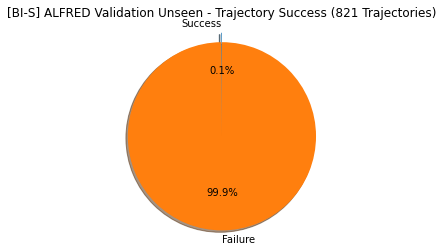

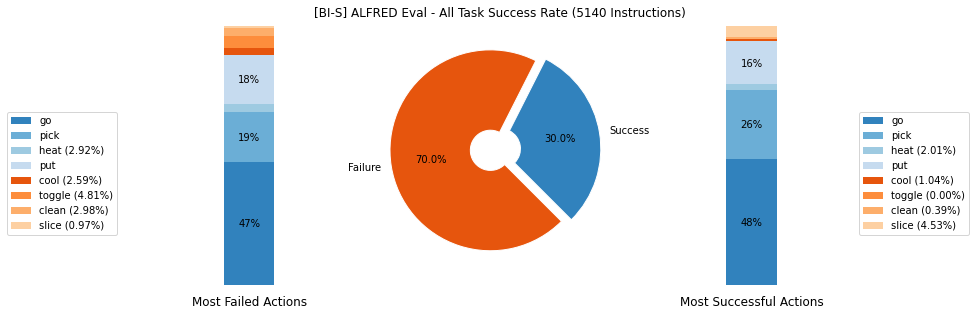

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

success = instruction_success

print("Tasks: ", len(subset))
print("Trajectories: ", len(trajectory_success))
print("Instructions: ", len(instruction_success))

succ_sum = 0
for i in success:
    succ_sum += i[0]

save_figures = True

# Trajectory pie chart
traj_success_count = sum(trajectory_success)
traj_fail_count = len(trajectory_success) - traj_success_count
print('Trajectory Successes: ', traj_success_count)
print('Trajectory Failures: ', traj_fail_count)
fig1, ax1 = plt.subplots()
ax1.pie([traj_success_count, traj_fail_count], explode=(0.0,0.1), labels=['Success','Failure'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title='[BI-S] ALFRED Validation Unseen - Trajectory Success (%d Trajectories)' % len(trajectory_success))
if save_figures:
    plt.savefig('[BI-S] ALFRED Validation Unseen - Trajectory Success.png', dpi=300, bbox_inches='tight')

# Instruction pie and bar chart
action_failure = {}
action_success = {}
task_instruction_lengths = {}

for i in success:
    if not i[1] in action_success:
        action_success[i[1]] = 0.0
    if not i[1] in action_failure:
        action_failure[i[1]] = 0.0
    if not i[1] in task_instruction_lengths:
        task_instruction_lengths[i[1]] = []
    if i[0] == 1.0:
        action_success[i[1]] += 1.0
    else:
        action_failure[i[1]] += 1.0
    task_instruction_lengths[i[1]].append(i[2])

action_list = list(action_success.keys())

print('Failure: ', action_failure)
print('Success: ', action_success)

for k, v in action_success.items():
    print(f"{k} = {(v / (action_failure[k]+v)) * 100.0:.2f}%")
    
# make figure and assign axis objects
fig = plt.figure(figsize=(9+4.5, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.subplots_adjust(wspace=0)

size = 0.2
vals = np.array([list(action_success.values()), list(action_failure.values())])
print(vals)

cmap = plt.get_cmap("tab20c")
pie_colors = cmap(np.arange(3)*4)
bar_colors = cmap(np.arange(8))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / np.sum(vals[1]) for i in vals[1]] #Failure values
width = .2
fail_labels = action_list[:]

for j in range(len(ratios)):
    height = ratios[j]
    ax1.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax1.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.1:
        ax1.text(xpos, ypos - 0.015, "%d%%" % (ax1.patches[j].get_height() * 100),
                 ha='center')
    else:
        fail_labels[j] = "{} ({:.2f}%)".format(fail_labels[j], ratios[j] * 100.0)

ax1.set_title('Most Failed Actions', y=-0.1)
ax1.legend(fail_labels, bbox_to_anchor=(0,0.25), loc="lower left",  bbox_transform=fig.transFigure)
ax1.axis('off')
ax1.set_xlim(- 2.5 * width, 2.5 * width)

# pie chart parameters
ax2.pie(vals.sum(axis=1), explode=(0.0,0.1), labels=('Success', 'Failure'), autopct='%1.1f%%',
        shadow=False, startangle=-45, radius=1., colors=pie_colors, wedgeprops=dict(width=0.8, edgecolor='w'))

ax2.set(title='[BI-S] ALFRED Eval - All Task Success Rate (%d Instructions)' % len(success))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / succ_sum for i in vals[0]] #Success values
width = .2

for j in range(len(ratios)):
    height = ratios[j]
    ax3.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax3.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.05:
        ax3.text(xpos, ypos - 0.015, "%d%%" % (ax3.patches[j].get_height() * 100),
                 ha='center')
    else:
        action_list[j] = "{} ({:.2f}%)".format(action_list[j], ratios[j] * 100.0)

ax3.set_title('Most Successful Actions', y=-0.1)
ax3.legend(action_list, bbox_to_anchor=(1,0.25), loc="lower right",  bbox_transform=fig.transFigure)
ax3.axis('off')
ax3.set_xlim(- 2.5 * width, 2.5 * width)

#plt.tight_layout()
if save_figures:
    plt.savefig('[BI-S] ALFRED_Eval-instructions-success.png', dpi=300, bbox_inches='tight')

In [ ]:
# Instruction Length Bar Chart
# Instruction length vs task success
plt.rcdefaults()
fig, ax = plt.subplots()

action_success_sorted = dict(sorted(action_success.items(), key=lambda item: item[1], reverse=True))
task_lengths_sorted = {}
for k in action_success_sorted.keys():
    task_lengths_sorted[k] = np.mean(task_instruction_lengths[k])

tasks = action_success_sorted.keys() # In order of success
y_pos = np.arange(len(tasks))
tasks_success = task_lengths_sorted.values()

ax.barh(y_pos, tasks_success, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(tasks)
ax.invert_yaxis()  # labels read top-to-bottom
rects = ax.patches
labels = ["%.2f%%" % ((i/succ_sum)*100.0) for i in action_success_sorted.values()]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + 0.55, label,
            ha='center', va='bottom')
ax.set_xlabel('Average Instruction Length')
ax.set_title('Comparing instruction length to task success')
if save_figures:
    plt.savefig('Comparing instruction length to task success.png', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import cv2
import pathlib

#=========================================================
#import torchtext

# Load FastText word vectors
#fast_text = torchtext.vocab.FastText(cache='../.vector_cache')

# Load ALFRED training data using torchtext
import torchtext.data as data

#  Basic english normalisation, lowers and seperates grammar
INSTRUCTION = data.Field(tokenize='basic_english', lower=True,
                         init_token='<sos>',
                         eos_token='<eos>',)
ACTION = data.Field(is_target=True)
ACTION_ARGUMENT_1 = data.Field(tokenize='basic_english',is_target=True)
ACTION_ARGUMENT_2 = data.Field(tokenize='basic_english',is_target=True)

ALFRED_DATA_ROOT = '../honours_research_repo/'
ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Train_InstActionArgs.tsv'
ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Validation_InstActionArgs.tsv'
ALFRED_TEST_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Test_InstActionArgs.tsv'

def filter_action(example):
    if example.action[0] == 'PickupObject':
        return True
    else:
        return False

train, val, test = data.TabularDataset.splits(
    path='', 
    train=ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME,
    validation=ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME,
    test=ALFRED_TEST_INSTRUCTION_TSV_FILENAME, format='tsv',
    fields=[('trajectory_number', None),
            ('task_description', None),
            ('instruction_number', None),
            ('instruction', INSTRUCTION),
            ('action', ACTION),
            ('action_argument_1', ACTION_ARGUMENT_1),
            ('action_argument_2', ACTION_ARGUMENT_2)
           ], 
    filter_pred=filter_action)

INSTRUCTION.build_vocab(train,vectors=__word_vec__) #'fasttext.en.300d')
ACTION.build_vocab(train)
ACTION_ARGUMENT_1.build_vocab(train,vectors=__word_vec__)
ACTION_ARGUMENT_2.build_vocab(train,vectors=__word_vec__)
#=========================================================